# Suyati residetial property retail portal project

### Overview:
In this project I'll be using a dataset of recent house listings in and around Austin, TX in order to create a **model that tries to predict the price listing of a house** based on several features. The dataset comes from Kaggle and is linked below. 
### Dataset:
https://www.kaggle.com/datasets/ericpierce/austinhousingprices?resource=download  ('austinHousingData.csv')

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import datetime
import os
import seaborn as sns
pd.pandas.set_option('display.max_columns',None)

In [2]:
%matplotlib inline

In [3]:
housing_data = pd.read_csv('austinHousingData.csv')

# Data Exploration & Analysis

In this section, I'll be getting an overall sense of the dataset by looking at some statistics and making visualizations. I'll be using this information to decide what might be useful for modeling.



In [4]:
housing_data.info(all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

## CHECKING FOR DUPLICATE VALUES

In [5]:
housing_data.duplicated().sum()

0

## SAMPLE FROM DATASET

In [6]:
housing_data.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_saledate,latest_salemonth,latest_saleyear,latestPriceSource,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,True,True,True,False,False,Single Family,2,2012,305000.0,5,2019-09-02,9,2019,"Coldwell Banker United, Realtors - South Austin",39,0,5,2,1,3,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,True,True,True,False,False,Single Family,2,2013,295000.0,1,2020-10-13,10,2020,Agent Provided,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,True,False,True,False,False,Single Family,0,2018,256125.0,1,2019-07-31,7,2019,Agent Provided,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,True,True,True,False,False,Single Family,2,2013,240000.0,4,2018-08-08,8,2018,Agent Provided,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,True,False,True,False,False,Single Family,0,2002,239900.0,3,2018-10-31,10,2018,Agent Provided,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


## We are not considering the following features for making the model :
  ### *zpid
  ### *zipcode
  ### *streetAddress
  ### *latestPriceSource
  ### *longitude
  ### *latitude
  ### *description
  ### *homeImage

zpid,zipcode,street address,latestPriceSource can't provide much influence to the model.

Reason for not including longitude and latitude as features for price prediction in the Austin housing dataset is that they may not provide direct and meaningful information about the housing prices. While longitude and latitude can indicate the geographical location of a property, the relationship between these coordinates and housing prices is not necessarily linear or straightforward.

Reason for not including the 'description' as a feature for price prediction is that the 'description' field is subjective and unstructured text data. Predictive models typically work with structured and quantitative features to make accurate predictions. The 'description' may contain a variety of information, including personal opinions, which may not have a direct and consistent relationship with the housing price.

Home Image may be considered in future,if it is possible after learning DL

In [7]:
housing_data = housing_data.drop(['homeImage','latestPriceSource','description','streetAddress','zpid','zipcode','latitude','longitude'], axis=1)

## Basic Statistics

Below is a summary of the statistics of the overall dataset. There's nothing too interesting for my purposes except for the  'latestPrice' column, which will be my label. It looks like the mean price is ~ $\$$510,000 and the median price is ~ $\$$450,000. The smallest price is $\$$5,500, and the largest is $\$$13,500,000.

In [8]:
housing_data.describe()

,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,15171.000000,15171.000000,15171.000000,15171.000000,1.517100e+04,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,1.517100e+04,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000,15171.000000
mean,1.994085,1.229187,1.224507,1988.554743,5.127677e+05,3.032892,6.733043,2019.078241,30.640432,0.012985,3.474722,1.710105,0.663371,0.466878,0.002768,0.208490,0.018852,1.190840e+05,2208.323314,0.940676,0.049173,1.035990,0.976798,1.838495,5.779912,1237.304660,14.857228,2.683010,3.440380,1.467273
std,0.053102,1.352117,1.352732,21.579458,4.531853e+05,2.487392,3.146760,0.813941,21.175174,0.179438,1.893351,0.788641,0.983779,0.824481,0.061771,0.488331,0.206775,1.225272e+07,1378.576119,0.236516,0.234937,0.263633,0.292043,1.068376,1.860276,326.513311,1.741857,1.054445,0.849942,0.523697
min,1.980000,0.000000,0.000000,1905.000000,5.500000e+03,1.000000,1.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+02,300.000000,0.000000,0.000000,0.000000,0.000000,0.200000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000
25%,1.980000,0.000000,0.000000,1974.000000,3.090000e+05,1.000000,4.000000,2018.000000,20.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.534000e+03,1483.000000,1.000000,0.000000,1.000000,1.000000,1.100000,4.000000,966.000000,14.000000,2.000000,3.000000,1.000000
50%,1.980000,1.000000,1.000000,1993.000000,4.050000e+05,2.000000,7.000000,2019.000000,29.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.276000e+03,1975.000000,1.000000,0.000000,1.000000,1.000000,1.566667,5.778694,1287.000000,15.000000,3.000000,3.000000,1.000000
75%,1.980000,2.000000,2.000000,2006.000000,5.750000e+05,4.000000,9.000000,2020.000000,39.000000,0.000000,4.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.089000e+04,2687.000000,1.000000,0.000000,1.000000,1.000000,2.266667,7.000000,1496.000000,16.000000,3.000000,4.000000,2.000000
max,2.210000,22.000000,22.000000,2020.000000,1.350000e+07,23.000000,12.000000,2021.000000,179.000000,8.000000,12.000000,6.000000,8.000000,6.000000,2.000000,4.000000,8.000000,1.508483e+09,109292.000000,2.000000,2.000000,3.000000,2.000000,9.000000,9.500000,1913.000000,19.000000,27.000000,20.000000,4.000000


## Data Visualizations

Now I want to get a better understanding of the distribution of home prices in the dataset. There are several kinds of charts that can help in this regard. I'll go ahead and use a pie chart, histogram, scatter plot, and box plot to visualize the data.



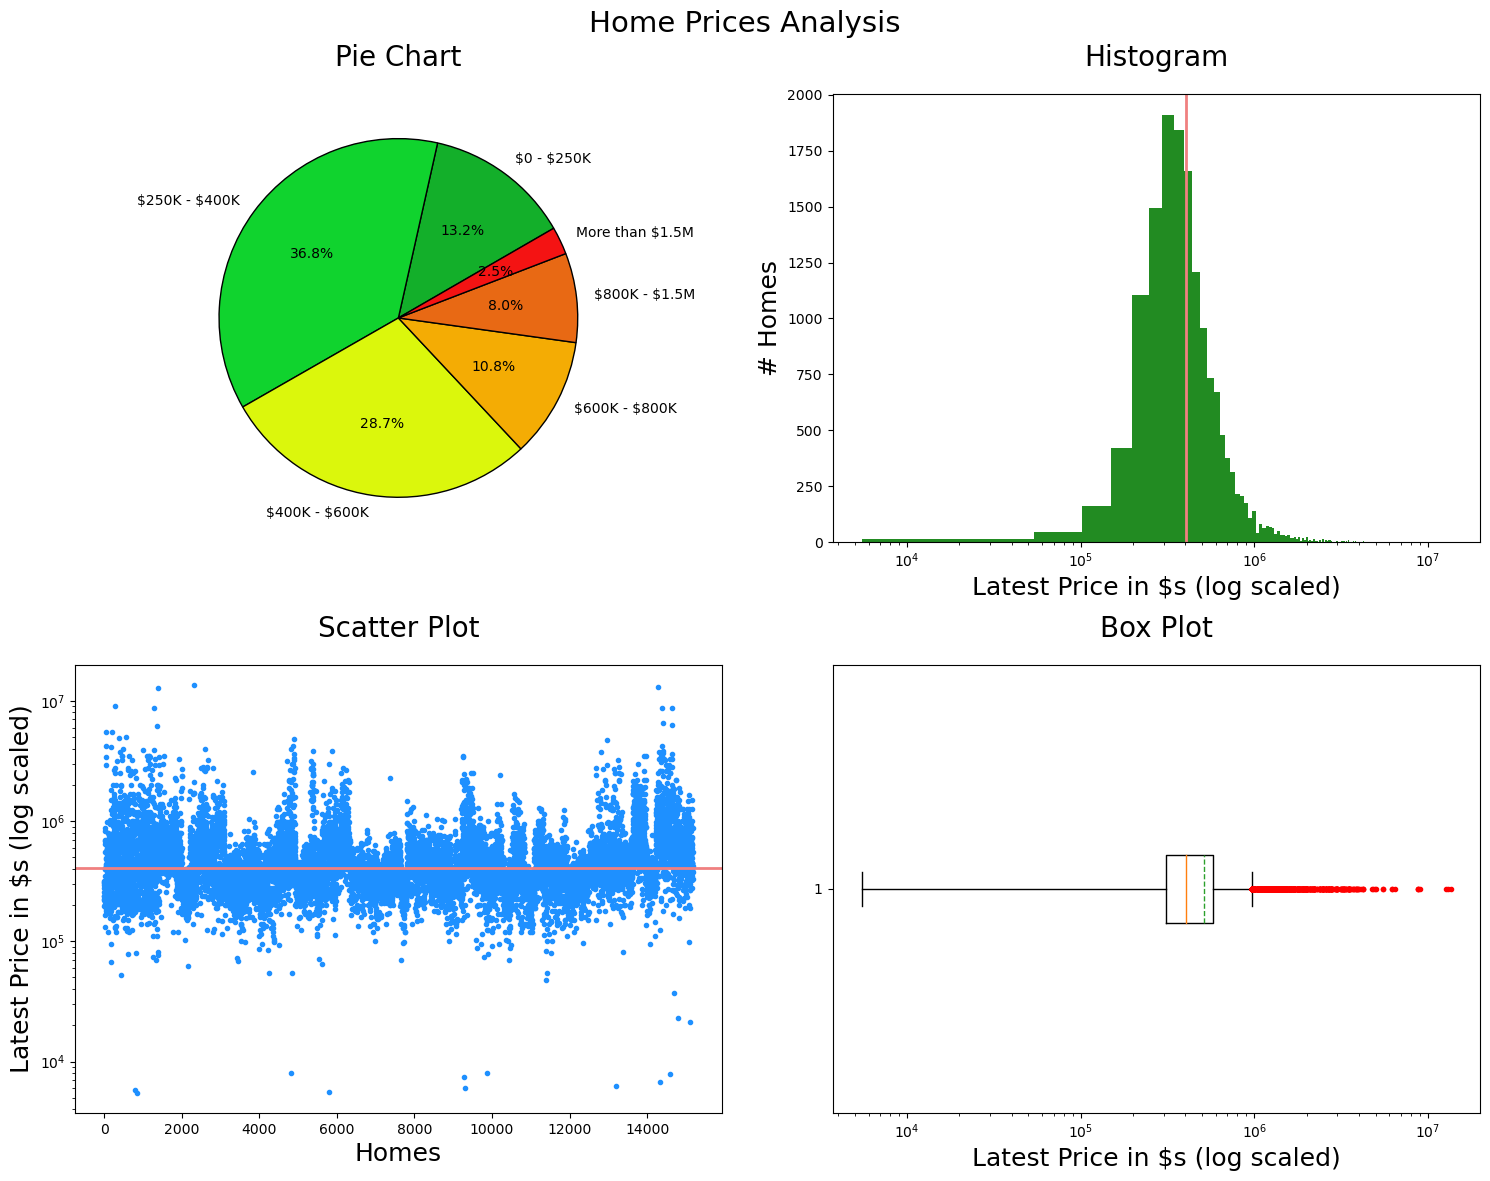

In [9]:
# Pie chart parameters
labels = ['\$0 - \$250K', '\$250K - \$400K', '\$400K - \$600K', '\$600K - \$800K', '\$800K - \$1.5M', 'More than \$1.5M']
colors = ['#13af2a', '#10d32e', '#dbf70c', '#f4ac04', '#e86914', '#f41313']
intervals = [0, 250000, 400000, 600000, 800000, 1500000, housing_data['latestPrice'].max()]  # in $s
chart_slice_sizes = housing_data.groupby(pd.cut(housing_data['latestPrice'], intervals)).size().values

# Create the parent figure
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 12)
fig.suptitle('Home Prices Analysis', size=21)

# Create pie chart
ax[0][0].set_title('Pie Chart', size=20, pad=20)
ax[0][0].pie(chart_slice_sizes, labels=labels, colors=colors, startangle=30, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})

# Create histogram
ax[0][1].set_title('Histogram', size=20, pad=20)
ax[0][1].hist(housing_data['latestPrice'], bins=280, color='forestgreen')
ax[0][1].set_ylabel('# Homes', size=18)
ax[0][1].set_xlabel('Latest Price in $s (log scaled)', size=18)
ax[0][1].set_xscale('log')
ax[0][1].axvline(housing_data['latestPrice'].median(), color='lightcoral', label='Median Price', linewidth=2)

# Create Scatterplot
ax[1][0].set_title('Scatter Plot', size=20, pad=20)
ax[1][0].scatter(range(len(housing_data)), housing_data['latestPrice'], marker='.', color='dodgerblue')
ax[1][0].set_ylabel('Latest Price in $s (log scaled)', size=18)
ax[1][0].set_xlabel('Homes', size=18)
ax[1][0].set_yscale('log')
ax[1][0].axhline(housing_data['latestPrice'].median(), color='lightcoral', label='Median Price', linewidth=2)

# Create Boxplot
ax[1][1].set_title('Box Plot', size=20, pad=20)
ax[1][1].boxplot(housing_data['latestPrice'], sym='r.', vert=False, showmeans=True, meanline=True)
ax[1][1].set_xlabel('Latest Price in $s (log scaled)', size=18)
ax[1][1].set_xscale('log')

fig.tight_layout()

plt.show()

# **Insights:**

### It appears that the majority of homes are between $\$$250K and $\$$600K (\%65.5). 
### The data has minimal spread as indicated by the histogram and scatter plot.
### It is also very apparent that there are outliers in the data. 
### The plots had to be log-scaled to show this more clearly. However, the fact that x is log-scaled gives the illusion that outliers to the left are more drastic (Ex: the tail is longer in the histogram). In actuality, values to the right are larger and more anomolous with respect to the whole dataset. The box plot shows this clearly, as all the outliers (highlighted in red) are on the right side.

### The above insights suggest that higher price values may be harder to predict, as they are more anomolous. 

In [10]:
len(housing_data.columns)

39

## Total number of features = 39

## Temporal Variables(Eg: Datetime Variables)

From the Dataset we have 2 year variables. We have extract information from the datetime variables like no of years or no of days. One example in this specific scenario can be difference in years between the year the house was built and the year the house was sold. We will be performing this analysis in the Feature Engineering .

In [11]:
# list of variables that contain year information
#year_feature = [feature for feature in lstnumericcolumns if 'year' in feature or 'Year' in feature]
year_feature = [feature for feature in housing_data.columns if 'year' in feature or 'Year' in feature or 'date' in feature]

year_feature

['yearBuilt', 'latest_saledate', 'latest_saleyear']

In [12]:
# let's explore the content of these year variables
for feature in year_feature:
    print(feature, housing_data[feature].unique())

yearBuilt [2012 2013 2018 2002 2020 2016 2005 2003 2010 2000 2009 2014 2007 2006
 2008 2015 1999 2004 1970 1985 1988 1992 1991 2011 1993 1989 1982 1990
 1996 1976 1997 1995 1987 2001 1983 1977 2017 1984 1971 1972 2019 1975
 1980 1994 1998 1986 1965 1962 1968 1979 1960 1978 1981 1957 1963 1974
 1973 1969 1939 1929 1950 1967 1964 1958 1955 1966 1961 1959 1956 1930
 1952 1949 1945 1940 1946 1947 1944 1948 1936 1935 1954 1927 1953 1937
 1925 1920 1919 1932 1914 1924 1910 1934 1941 1938 1909 1933 1928 1916
 1917 1931 1942 1951 1926 1915 1907 1943 1906 1911 1921 1912 1923 1908
 1922 1918 1905]
latest_saledate ['2019-09-02' '2020-10-13' '2019-07-31' '2018-08-08' '2018-10-31'
 '2020-08-05' '2020-06-11' '2018-10-10' '2019-09-19' '2018-09-11'
 '2020-08-28' '2019-04-12' '2020-09-05' '2018-12-15' '2020-08-18'
 '2020-06-02' '2019-02-27' '2018-08-28' '2018-12-03' '2020-12-22'
 '2020-01-10' '2020-12-07' '2018-03-13' '2019-03-29' '2020-12-31'
 '2020-12-04' '2020-04-22' '2018-01-30' '2020-11-09' '2020-

Text(0.5, 1.0, 'House Price vs YearSold')

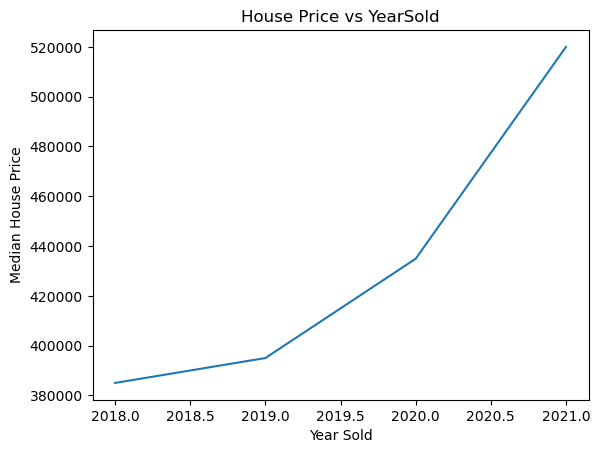

In [13]:
## Lets analyze the Temporal Datetime Variables
## We will check whether there is a relation between year the house is sold and the sales price

housing_data.groupby('latest_saleyear')['latestPrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('Median House Price')
plt.title("House Price vs YearSold")



### The home price is rising as the years go by.

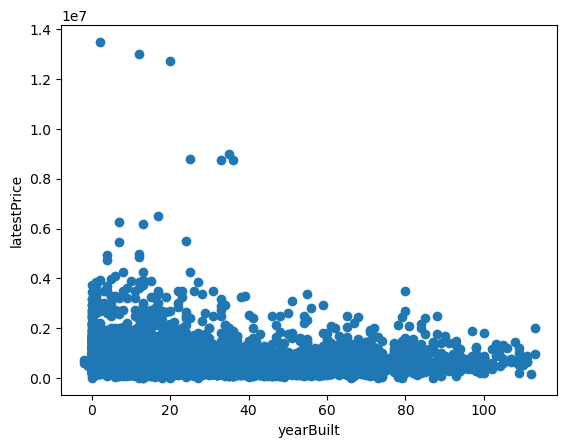

In [14]:
## Here we will compare the difference between All years feature with SalePrice

for feature in year_feature:
    if feature!='latest_saleyear' and feature != 'latest_saledate':
        data=housing_data.copy()
        ## We will capture the difference between year variable and year the house was sold for
        data[feature]=data['latest_saleyear']-data[feature]

        plt.scatter(data[feature],data['latestPrice'])
        plt.xlabel(feature)
        plt.ylabel('latestPrice')
        plt.show()

    
    

### As the number of years since construction increases, the price of the home decreases.

In [15]:
import calendar
months = []
for item in housing_data['latest_salemonth']:
    month = calendar.month_name[item]
    months.append(month)
month1 = pd.DataFrame(months, columns=['sale month'])
df = pd.concat([month1['sale month'], housing_data['latestPrice']], axis=1)




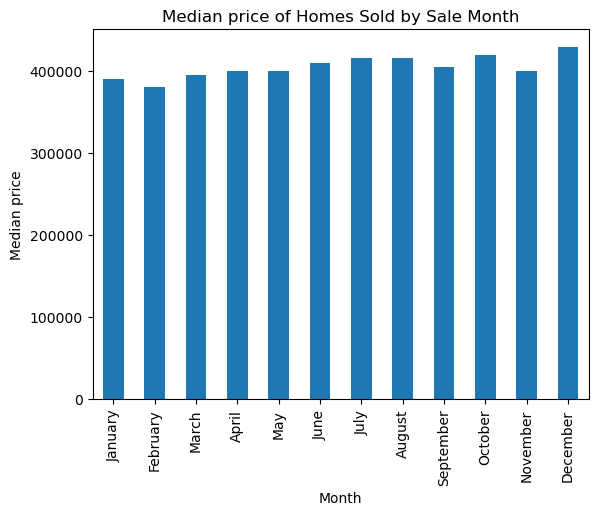

In [16]:
# Define the custom order of months
custom_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Group the data and calculate the median price sold by sale month
monthly_counts = df.groupby('sale month')['latestPrice'].median()

# Reindex the series with the custom order
monthly_counts = monthly_counts.reindex(custom_order)

# Plot the bar chart
monthly_counts.plot.bar()
plt.xlabel('Month')
plt.ylabel('Median price')
plt.title('Median price of Homes Sold by Sale Month')
plt.show()


In [17]:
dom = []
for item in housing_data['latest_saledate']:
    
    # Convert the object to a date object
    date_object = datetime.datetime.strptime(item, "%Y-%m-%d")
    # Extract day of the month
    day_of_month = date_object.day

    dom.append(day_of_month)
dayofm = pd.DataFrame(dom, columns=['day of month'])

new_df2 = pd.concat([dayofm['day of month'], housing_data['latestPrice']], axis=1)



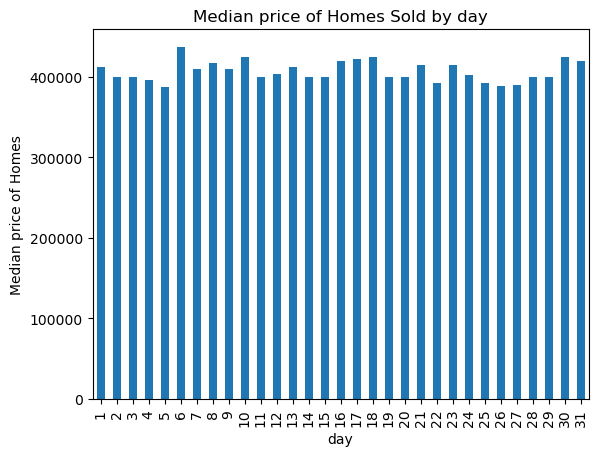

In [18]:
# Group the data and count the number of homes sold by sale month
dom_median = new_df2.groupby('day of month')['latestPrice'].median()


# Reindex the series with the custom order
#day_median = day_median.reindex(custom_order)

# Plot the bar chart
dom_median.plot.bar()
plt.xlabel('day')
plt.ylabel('Median price of Homes')
plt.title('Median price of Homes Sold by day')
plt.show()


In [19]:
import datetime
day = []
for item in housing_data['latest_saledate']:
    
    # Convert the object to a date object
    date = datetime.datetime.strptime(item, "%Y-%m-%d")

    day_of_week = date.strftime('%A')
    day.append(day_of_week)
# Convert the list to a dataframe
days = pd.DataFrame(day, columns=['day of week'])

new_df = pd.concat([days['day of week'], housing_data['latestPrice']], axis=1)

    



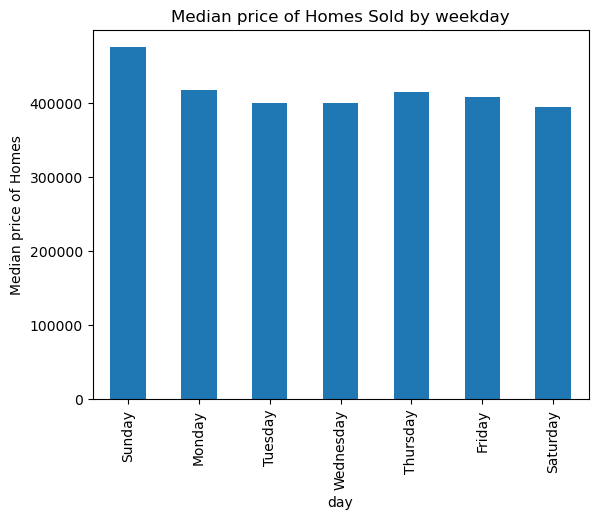

In [20]:
## We will check whether there is a relation between weekday the house is sold and the sales price


# Define the custom order of months
custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Group the data and count the number of homes sold by sale month
day_median = new_df.groupby('day of week')['latestPrice'].median()


# Reindex the series with the custom order
day_median = day_median.reindex(custom_order)

# Plot the bar chart
day_median.plot.bar()
plt.xlabel('day')
plt.ylabel('Median price of Homes')
plt.title('Median price of Homes Sold by weekday')
plt.show()


### Its clear from the bar chart that,there is no specific pattern in the price according to the week day,even though sunday has higher price all other days have almost same range.

### Details regarding month and year of latest sale is present as seperate feature in the dataset.So we can remove the feature latest sale date because there is no any pattern or trend in price accordig to the day of mnth or week day.

In [21]:
housing_data = housing_data.drop(['latest_saledate'], axis=1)

## Numerical Variables

In [22]:
data_num = housing_data.select_dtypes(include = ['float64', 'int64'])
lstnumericcolumns = list(data_num.columns.values)
print('Number of numerical variables: ', len(lstnumericcolumns))

# visualise the numerical variables
housing_data[lstnumericcolumns].head()


Number of numerical variables:  30


,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
0,1.98,2,2,2012,305000.0,5,9,2019,39,0,5,2,1,3,0,1,0,6011.0,2601.0,1,0,1,1,1.266667,2.666667,1063,14,3.0,4,2
1,1.98,2,2,2013,295000.0,1,10,2020,29,0,1,2,0,0,0,0,0,6185.0,1768.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,4,1
2,1.98,0,0,2018,256125.0,1,7,2019,2,0,4,1,0,1,0,0,0,7840.0,1478.0,0,2,1,1,1.200000,3.000000,1108,14,2.0,3,1
3,1.98,2,2,2013,240000.0,4,8,2018,9,0,0,2,0,0,0,0,0,6098.0,1678.0,1,0,1,1,1.400000,2.666667,1063,14,2.0,3,1
4,1.98,0,0,2002,239900.0,3,10,2018,27,0,0,1,0,0,0,0,0,6708.0,2132.0,1,0,1,1,1.133333,4.000000,1223,14,3.0,3,2


In [23]:
## Numerical variables are usually of 2 type
## 1. Continous variable and Discrete Variables

discrete_feature=[feature for feature in lstnumericcolumns if len(housing_data[feature].unique())<25 and feature not in year_feature]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 21


In [24]:
discrete_feature

['propertyTaxRate',
 'garageSpaces',
 'parkingSpaces',
 'numPriceChanges',
 'latest_salemonth',
 'numOfAccessibilityFeatures',
 'numOfAppliances',
 'numOfParkingFeatures',
 'numOfPatioAndPorchFeatures',
 'numOfSecurityFeatures',
 'numOfWaterfrontFeatures',
 'numOfWindowFeatures',
 'numOfCommunityFeatures',
 'numOfPrimarySchools',
 'numOfElementarySchools',
 'numOfMiddleSchools',
 'numOfHighSchools',
 'MedianStudentsPerTeacher',
 'numOfBathrooms',
 'numOfBedrooms',
 'numOfStories']

In [25]:
housing_data[discrete_feature].head()

,propertyTaxRate,garageSpaces,parkingSpaces,numPriceChanges,latest_salemonth,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
0,1.98,2,2,5,9,0,5,2,1,3,0,1,0,1,0,1,1,14,3.0,4,2
1,1.98,2,2,1,10,0,1,2,0,0,0,0,0,1,0,1,1,14,2.0,4,1
2,1.98,0,0,1,7,0,4,1,0,1,0,0,0,0,2,1,1,14,2.0,3,1
3,1.98,2,2,4,8,0,0,2,0,0,0,0,0,1,0,1,1,14,2.0,3,1
4,1.98,0,0,3,10,0,0,1,0,0,0,0,0,1,0,1,1,14,3.0,3,2


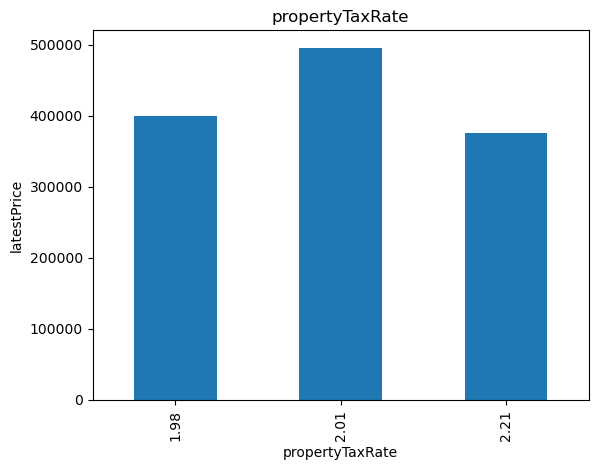

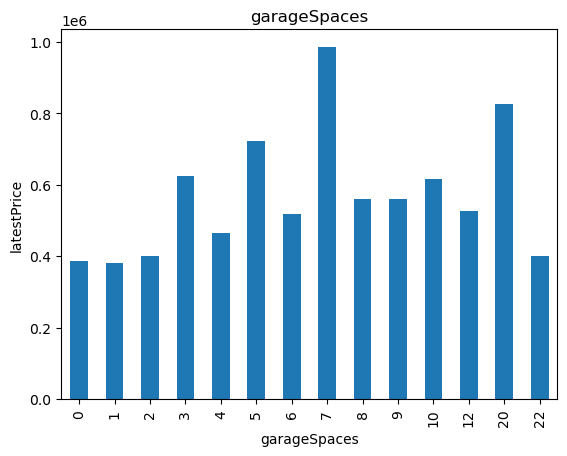

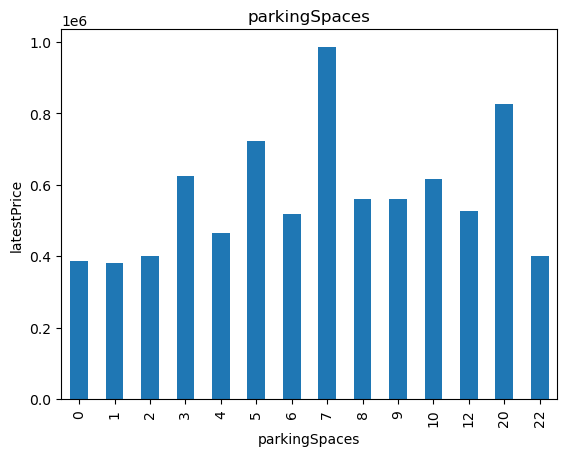

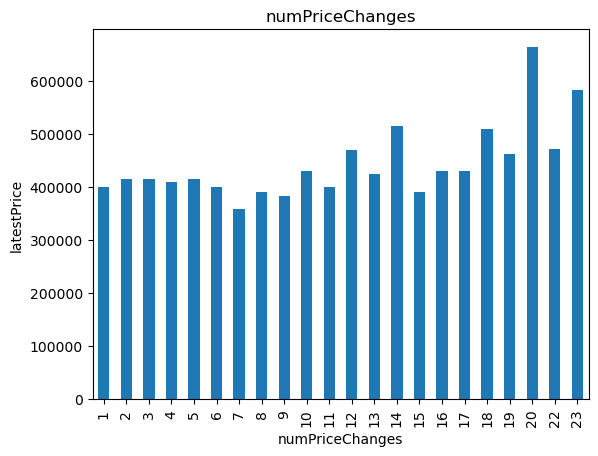

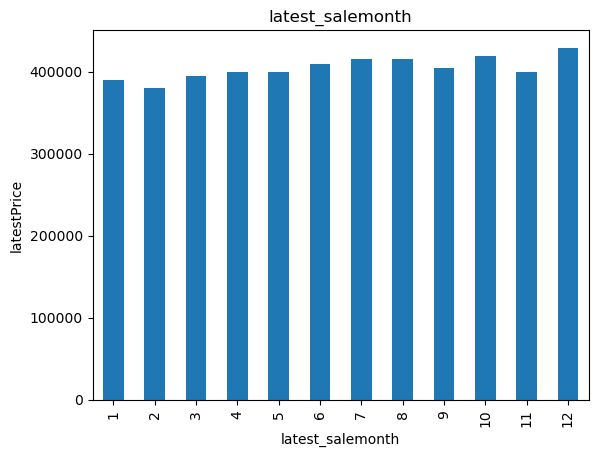

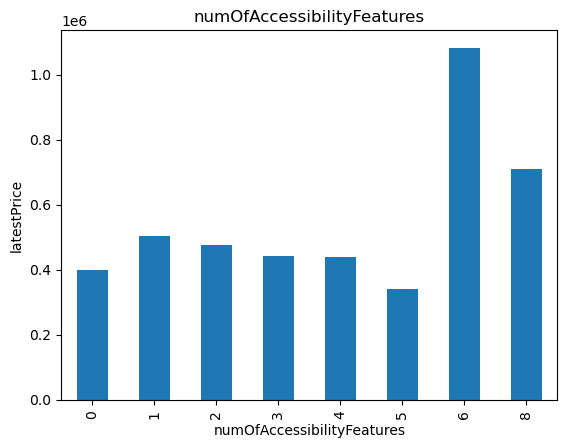

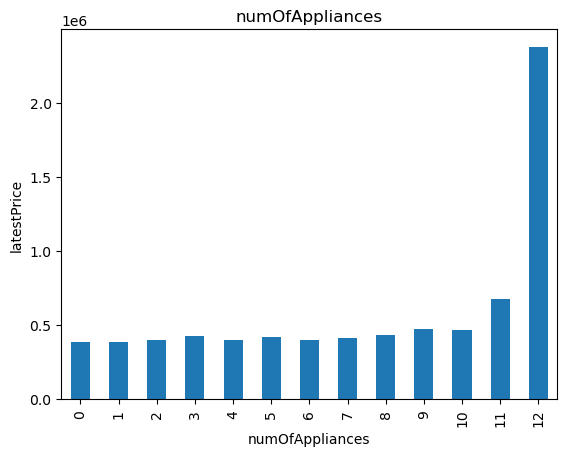

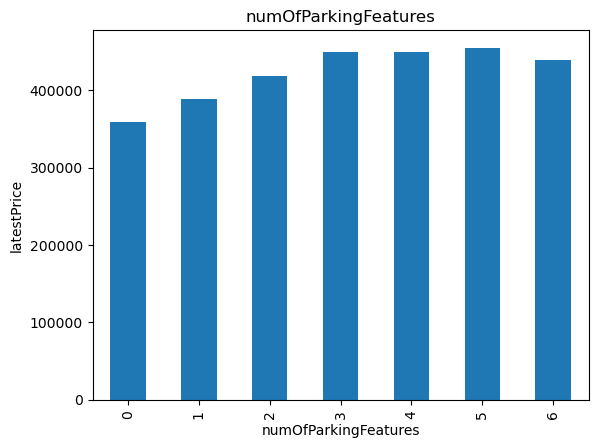

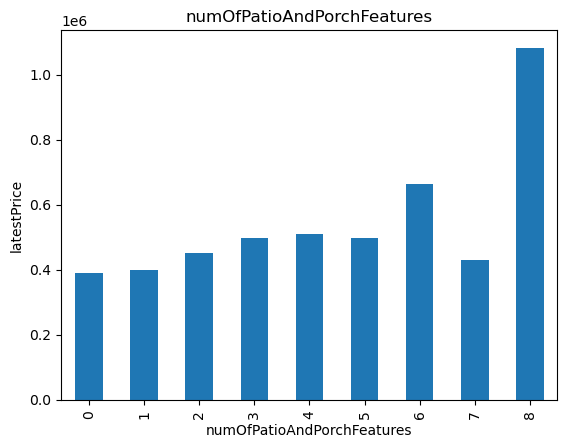

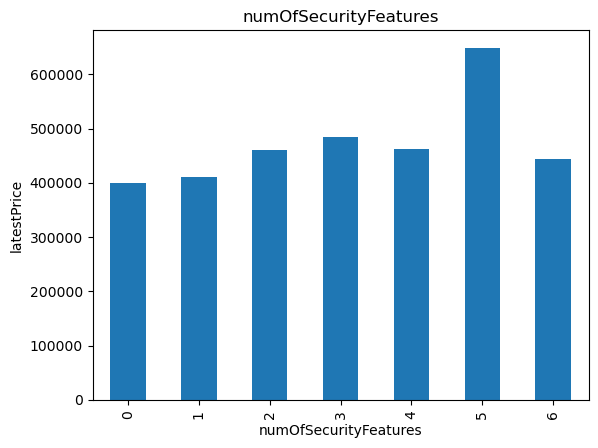

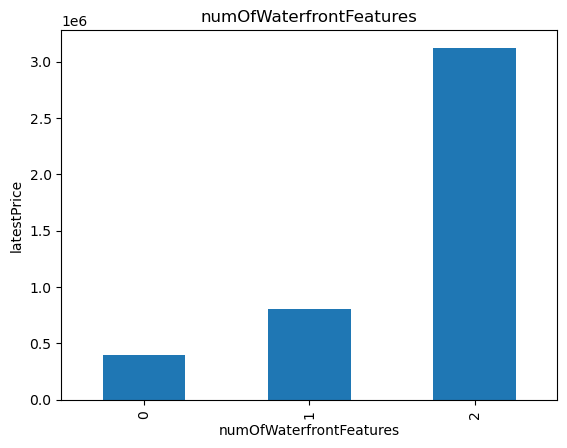

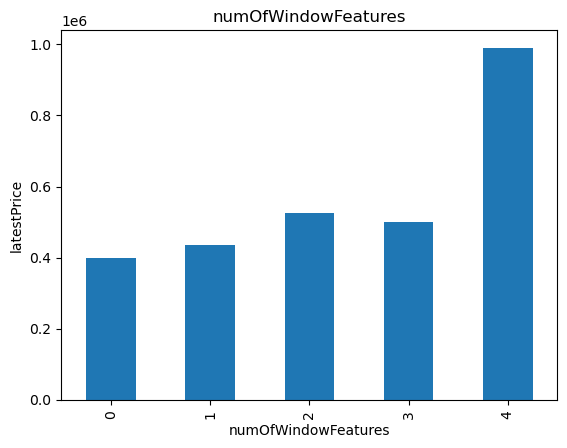

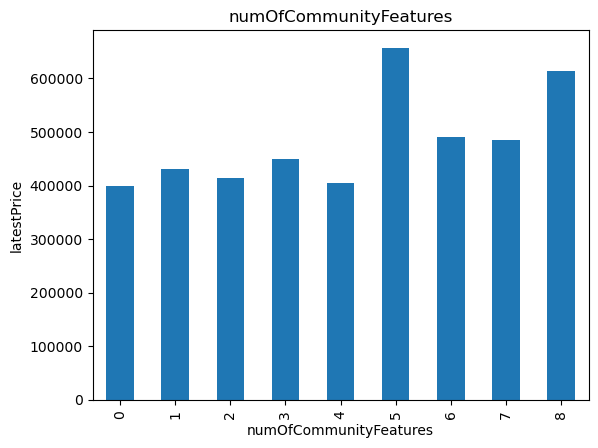

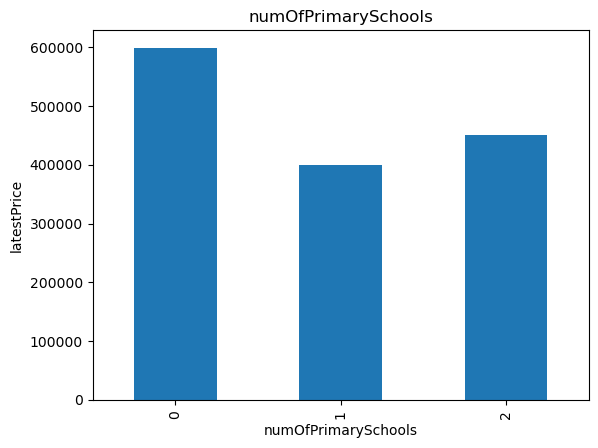

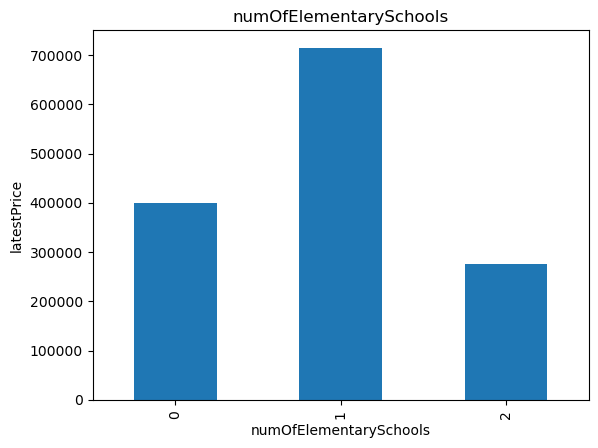

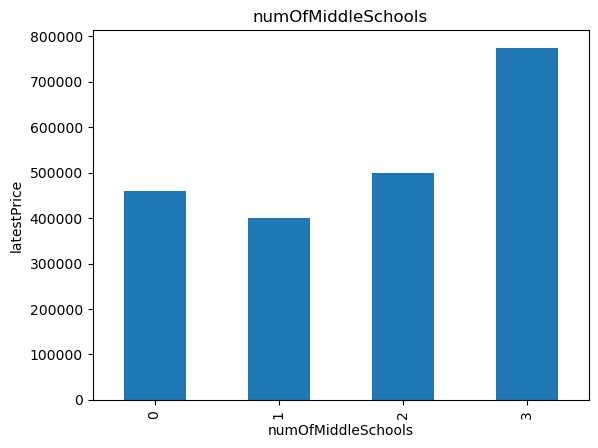

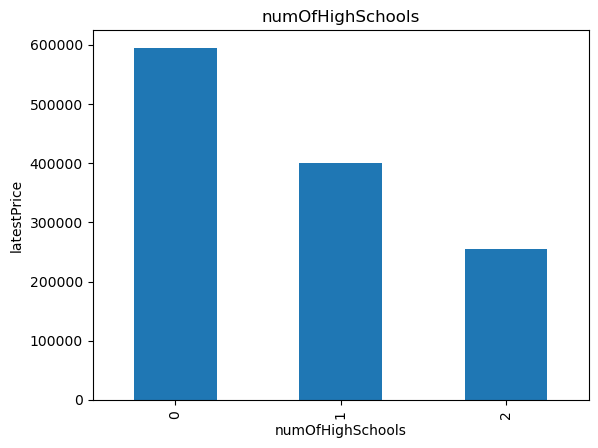

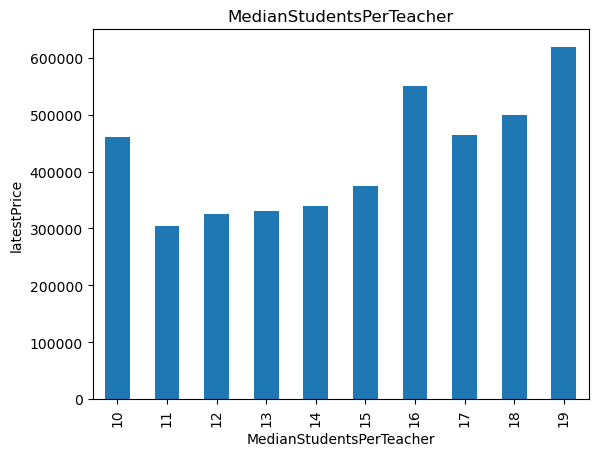

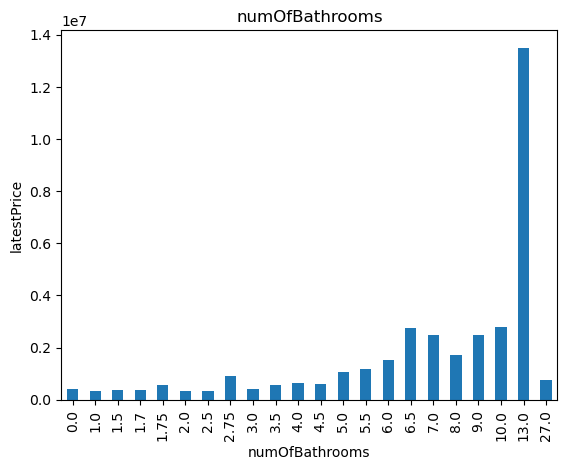

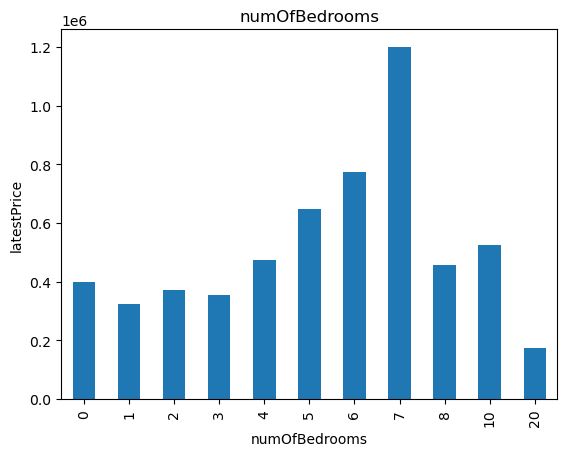

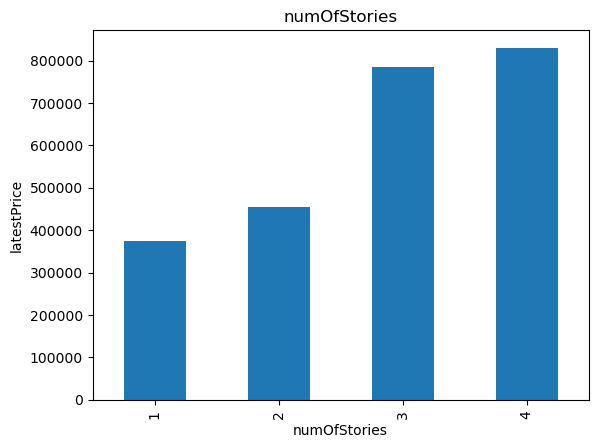

In [26]:
## Lets Find the realtionship between them and Sale PRice

for feature in discrete_feature:
    data=housing_data.copy()
    data.groupby(feature)['latestPrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('latestPrice')
    plt.title(feature)
    plt.show()

### We can see from the graph ,There is a relationship between variable number and SalePrice
### while observing the num of bathrooms feature in the chart ,we can find values with decimal point,we can verify it

In [27]:
housing_data['numOfBathrooms'].unique()

array([ 3.  ,  2.  ,  6.  ,  4.  ,  5.  ,  7.  ,  8.  ,  1.  ,  2.5 ,
       10.  ,  6.5 ,  0.  ,  3.5 ,  4.5 ,  5.5 ,  2.75, 13.  , 27.  ,
        1.5 ,  1.75,  9.  ,  1.7 ])

## decimal points are not possible for bathroom numbers.Number of bathrooms is one of the important feature  of house which user will look

In [28]:
import math
def round_up(x):
    return math.ceil(x)
housing_data['numOfBathrooms'] = housing_data['numOfBathrooms'].apply(round_up)


In [29]:
housing_data['numOfBathrooms'].unique()

array([ 3,  2,  6,  4,  5,  7,  8,  1, 10,  0, 13, 27,  9])

### Continuous Variable

In [30]:
continuous_feature=[feature for feature in lstnumericcolumns if feature not in discrete_feature+year_feature+['latest_salemonth']]
print("Continuous feature Count : {}".format(len(continuous_feature)))

Continuous feature Count : 7


In [31]:
continuous_feature

['latestPrice',
 'numOfPhotos',
 'lotSizeSqFt',
 'livingAreaSqFt',
 'avgSchoolDistance',
 'avgSchoolRating',
 'avgSchoolSize']

<Figure size 1000x200 with 0 Axes>

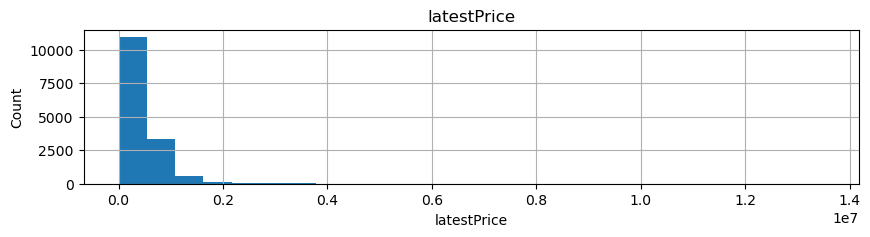

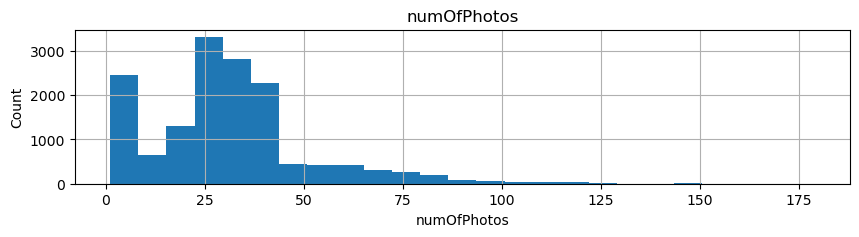

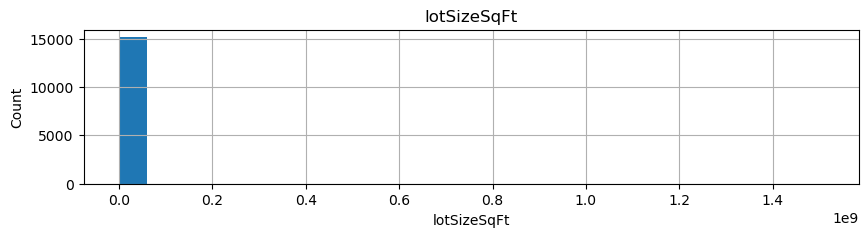

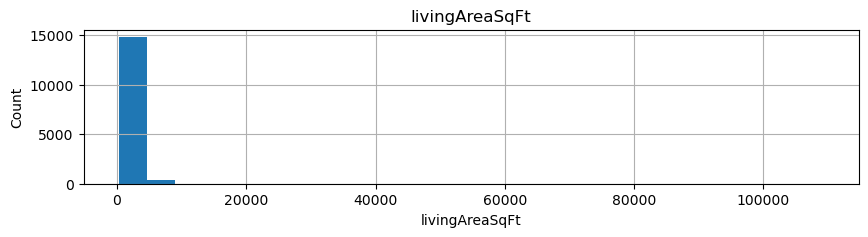

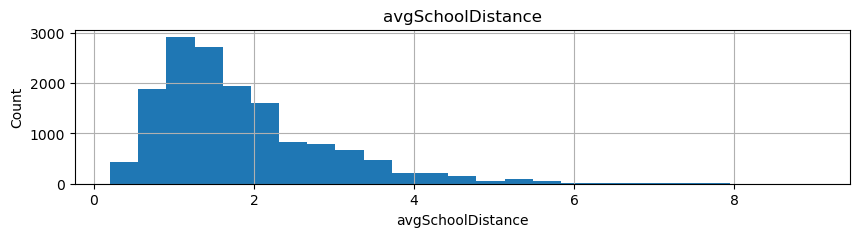

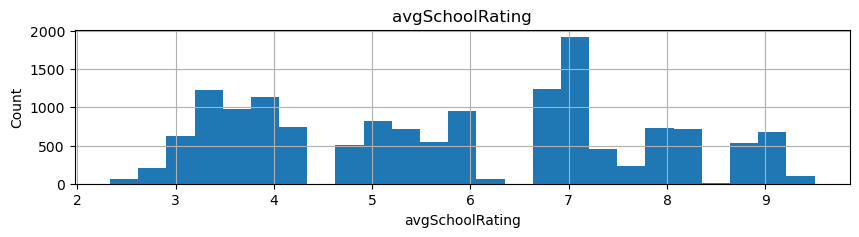

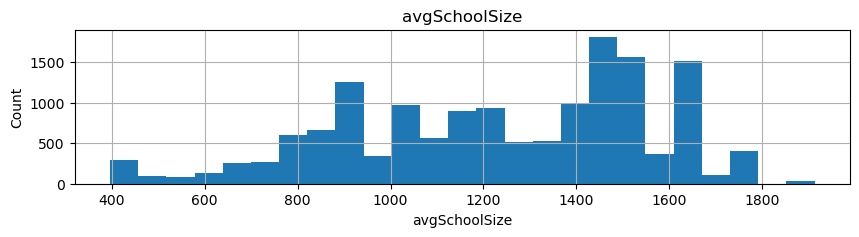

In [32]:
## Lets analyse the continuous values by creating histograms to understand the distribution
fig = plt.figure(figsize=(10, 2))
for feature in continuous_feature:
    fig = plt.figure(figsize=(10, 2))
    data=housing_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()


## Categorical Feature

In [33]:
categorical_features=[feature for feature in housing_data.columns if housing_data[feature].dtype=='bool' or housing_data[feature].dtype=='O' ]
categorical_features

['city',
 'hasAssociation',
 'hasCooling',
 'hasGarage',
 'hasHeating',
 'hasSpa',
 'hasView',
 'homeType']

In [34]:
housing_data[categorical_features].head()

,city,hasAssociation,hasCooling,hasGarage,hasHeating,hasSpa,hasView,homeType
0,pflugerville,True,True,True,True,False,False,Single Family
1,pflugerville,True,True,True,True,False,False,Single Family
2,pflugerville,True,True,False,True,False,False,Single Family
3,pflugerville,True,True,True,True,False,False,Single Family
4,pflugerville,True,True,False,True,False,False,Single Family


In [35]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(housing_data[feature].unique())))

The feature is city and number of categories are 9
The feature is hasAssociation and number of categories are 2
The feature is hasCooling and number of categories are 2
The feature is hasGarage and number of categories are 2
The feature is hasHeating and number of categories are 2
The feature is hasSpa and number of categories are 2
The feature is hasView and number of categories are 2
The feature is homeType and number of categories are 10


In [36]:
## Find out the relationship between categorical variable and dependent feature SalesPrice

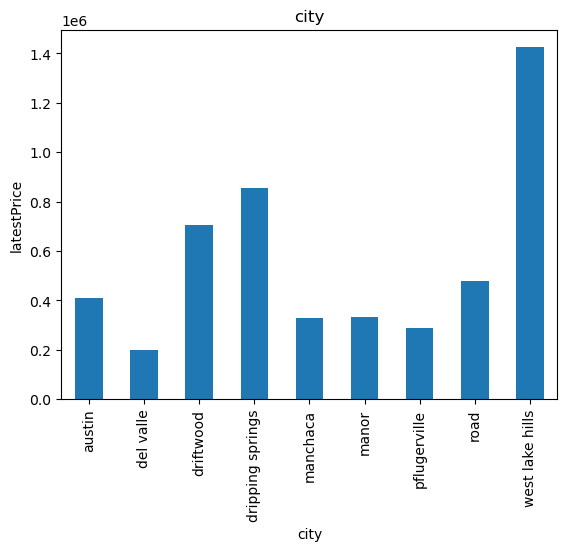

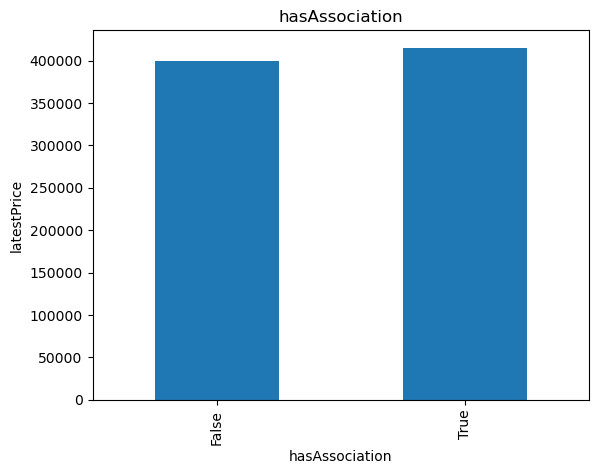

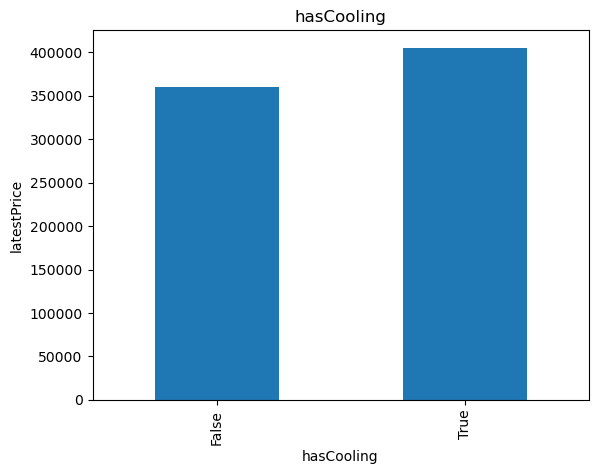

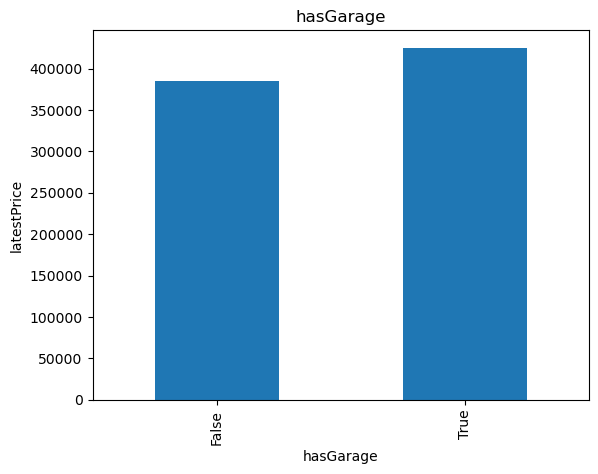

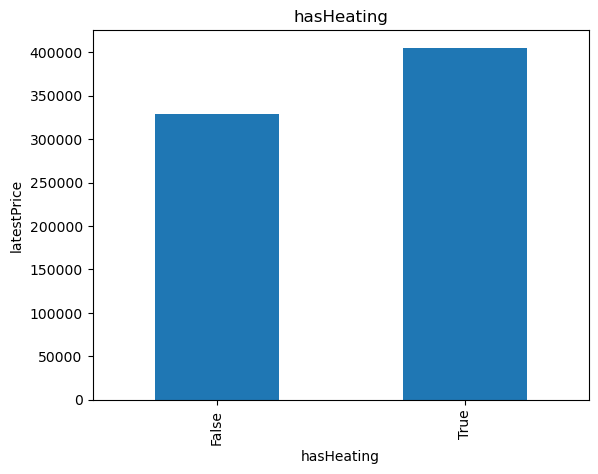

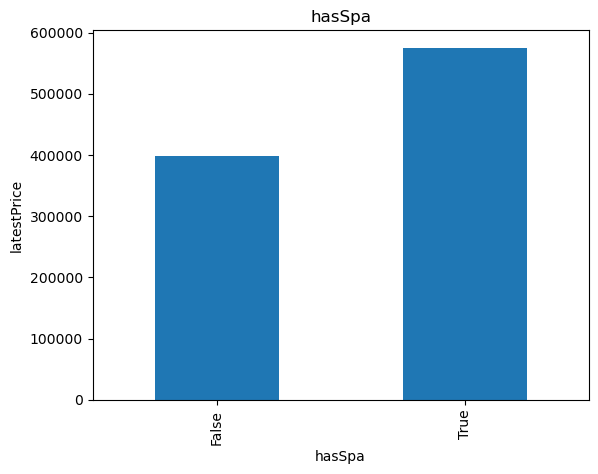

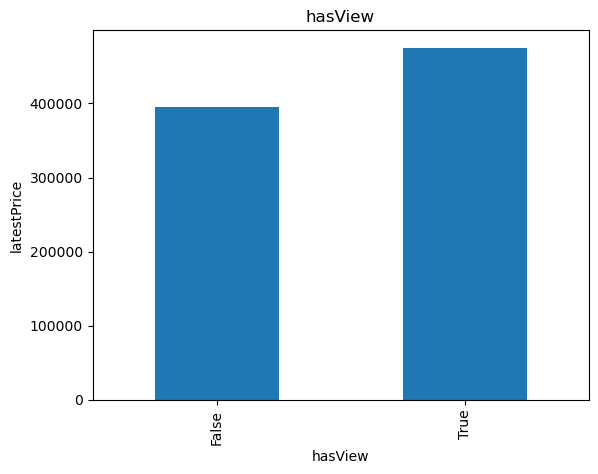

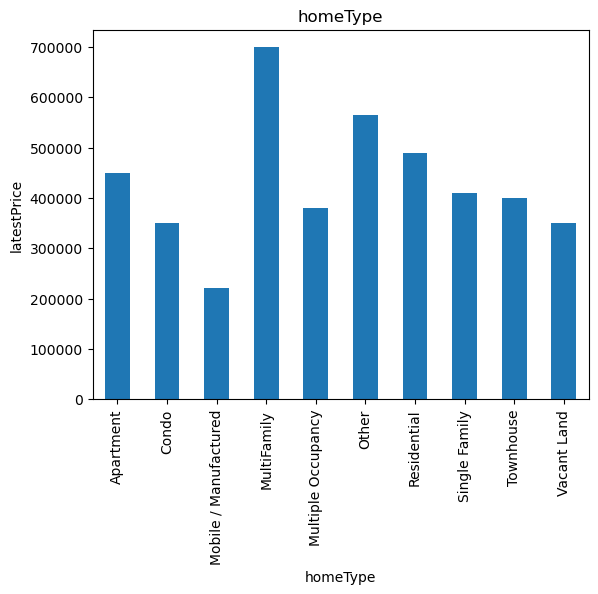

In [37]:
for feature in categorical_features:
    data=housing_data.copy()
    data.groupby(feature)['latestPrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('latestPrice')
    plt.title(feature)
    plt.show()

### All other categorical features except city and home type is directly related to the price of home

## Handling Rare Categorical Feature

In [38]:
housing_data['city'].value_counts()

austin              15020
del valle              86
pflugerville           36
driftwood              12
manor                   6
dripping springs        5
manchaca                3
west lake hills         2
road                    1
Name: city, dtype: int64

## since majority(99%) of data has city as Austin.There will not be much effect in including city as feature for model building

In [39]:
housing_data = housing_data.drop(['city'], axis=1)

In [40]:
housing_data['homeType'].value_counts()

Single Family            14241
Condo                      470
Townhouse                  174
Multiple Occupancy          96
Vacant Land                 83
Residential                 37
Apartment                   37
Mobile / Manufactured       17
MultiFamily                 10
Other                        6
Name: homeType, dtype: int64

## since majority(93%) of data has homeType as Single Family .There will not be much effect in including homeTypeas feature for model building

In [41]:
housing_data = housing_data.drop(['homeType'], axis=1)

## DEALING OUTLIERS


 Outliers can have a disproportionate impact on machine learning models, affecting their performance and generalization ability. Models that are sensitive to outliers may overly prioritize these extreme values, leading to poor predictions or unstable behavior. By handling outliers in numerical features, we can help models focus on the majority of the data points and improve their overall performance.

In [42]:
Q1 = data_num.quantile(0.25)
Q3 = data_num.quantile(0.75)
IQR = Q3 - Q1
((data_num < (Q1 - 1.5 * IQR)) | (data_num > (Q3 + 1.5 * IQR))).sum()

propertyTaxRate               1416
garageSpaces                   146
parkingSpaces                  146
yearBuilt                       93
latestPrice                   1071
numPriceChanges                618
latest_salemonth                 0
latest_saleyear                  0
numOfPhotos                    967
numOfAccessibilityFeatures     120
numOfAppliances                529
numOfParkingFeatures           240
numOfPatioAndPorchFeatures     934
numOfSecurityFeatures          536
numOfWaterfrontFeatures         34
numOfWindowFeatures           2651
numOfCommunityFeatures         209
lotSizeSqFt                   1316
livingAreaSqFt                 447
numOfPrimarySchools            902
numOfElementarySchools         682
numOfMiddleSchools             435
numOfHighSchools              1302
avgSchoolDistance              697
avgSchoolRating                  0
avgSchoolSize                    0
MedianStudentsPerTeacher        43
numOfBathrooms                 780
numOfBedrooms       

In [43]:
def univariateAnalysis_numeric(column,nbins):
    plt.figure()
    print("BoxPlot of " + column)
    print("----------------------------------------------------------------------------")
    ax = sns.boxplot(x=data_num[column])
    plt.show()

BoxPlot of propertyTaxRate
----------------------------------------------------------------------------


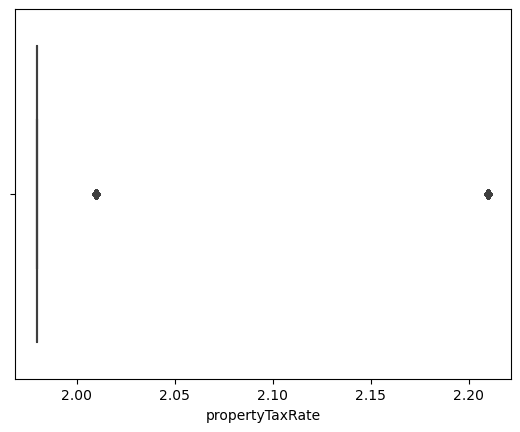

BoxPlot of garageSpaces
----------------------------------------------------------------------------


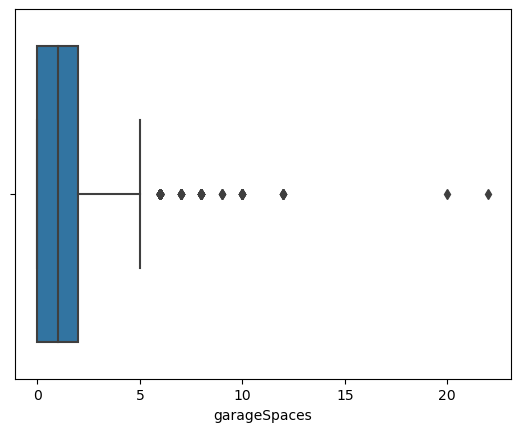

BoxPlot of parkingSpaces
----------------------------------------------------------------------------


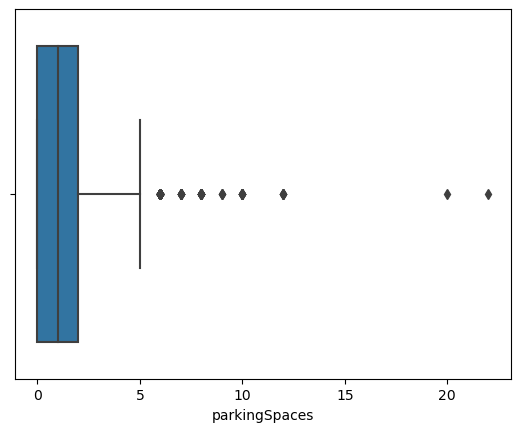

BoxPlot of yearBuilt
----------------------------------------------------------------------------


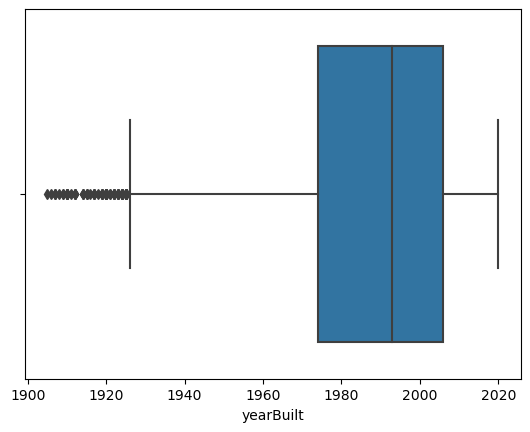

BoxPlot of latestPrice
----------------------------------------------------------------------------


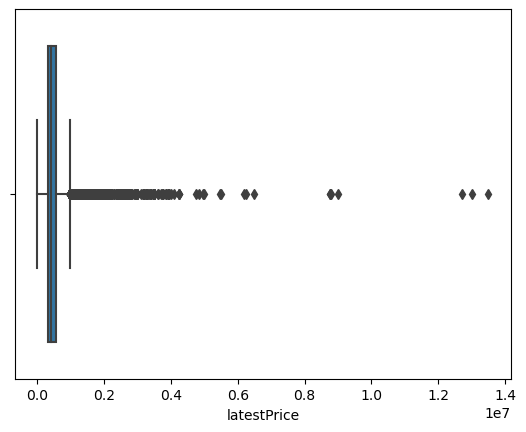

BoxPlot of numPriceChanges
----------------------------------------------------------------------------


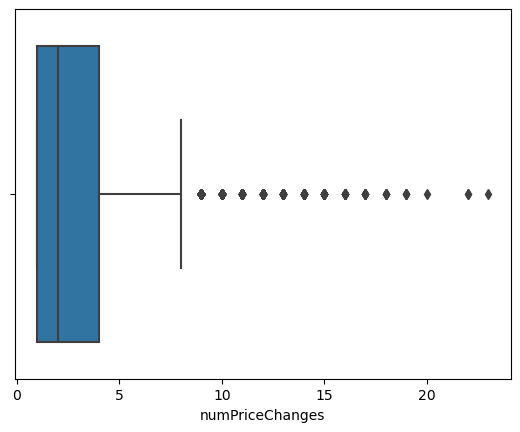

BoxPlot of latest_salemonth
----------------------------------------------------------------------------


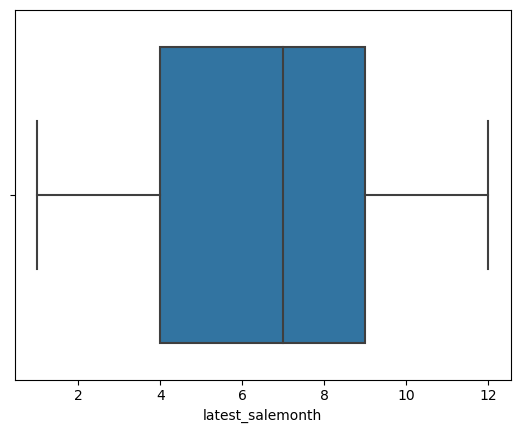

BoxPlot of latest_saleyear
----------------------------------------------------------------------------


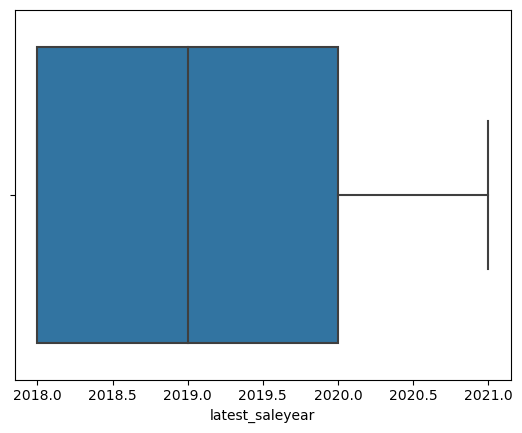

BoxPlot of numOfPhotos
----------------------------------------------------------------------------


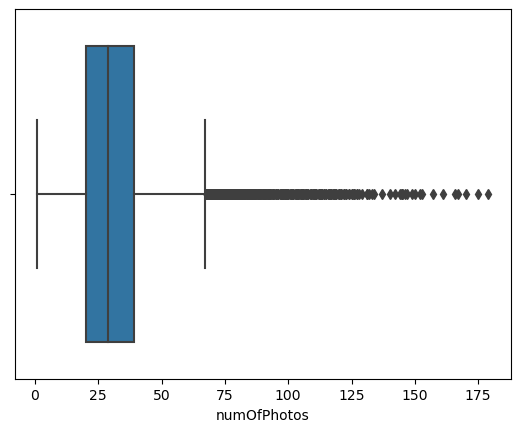

BoxPlot of numOfAccessibilityFeatures
----------------------------------------------------------------------------


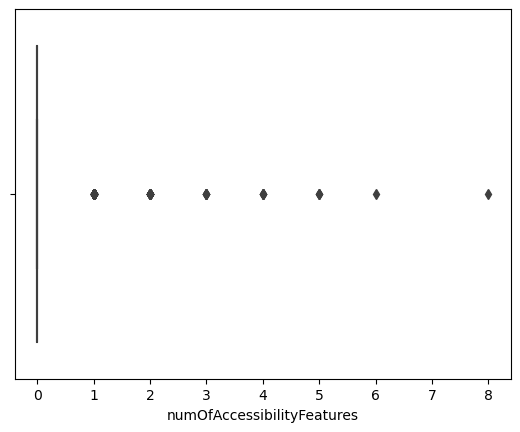

BoxPlot of numOfAppliances
----------------------------------------------------------------------------


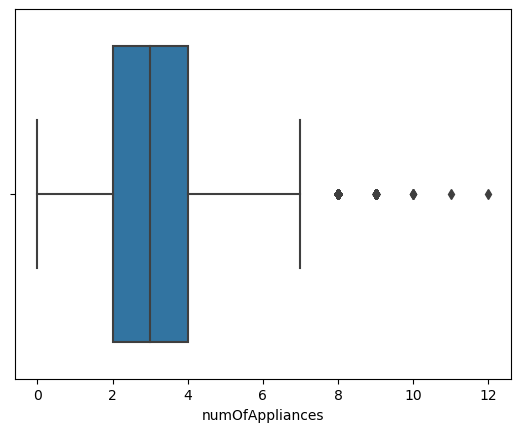

BoxPlot of numOfParkingFeatures
----------------------------------------------------------------------------


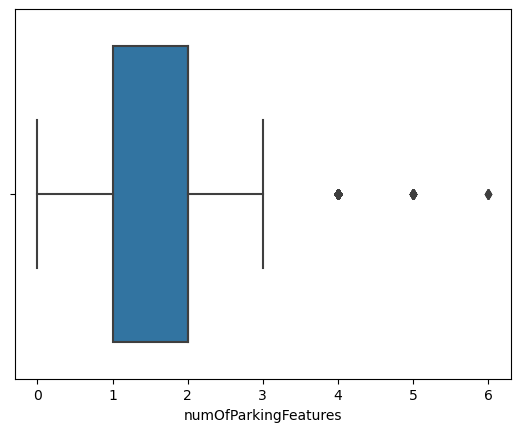

BoxPlot of numOfPatioAndPorchFeatures
----------------------------------------------------------------------------


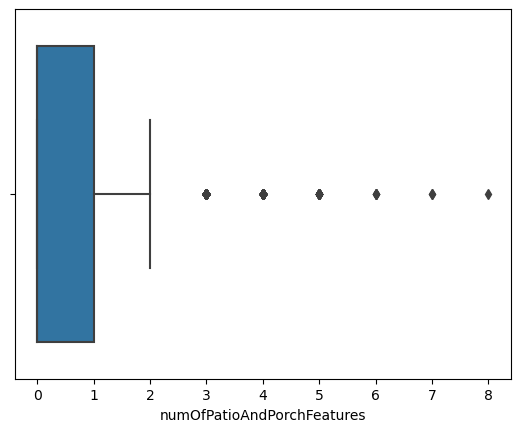

BoxPlot of numOfSecurityFeatures
----------------------------------------------------------------------------


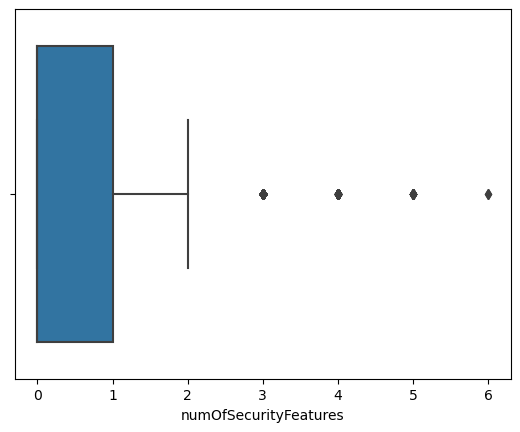

BoxPlot of numOfWaterfrontFeatures
----------------------------------------------------------------------------


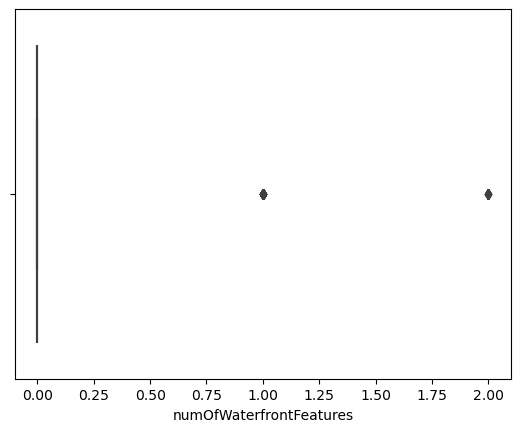

BoxPlot of numOfWindowFeatures
----------------------------------------------------------------------------


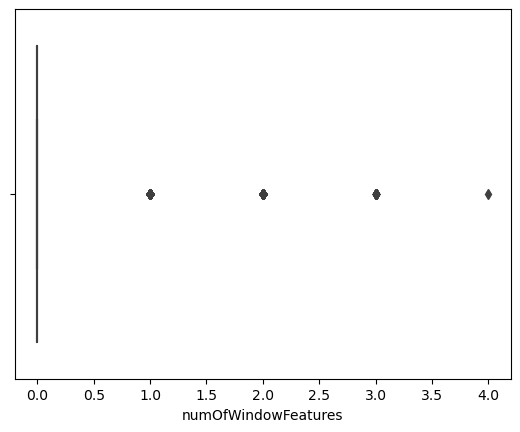

BoxPlot of numOfCommunityFeatures
----------------------------------------------------------------------------


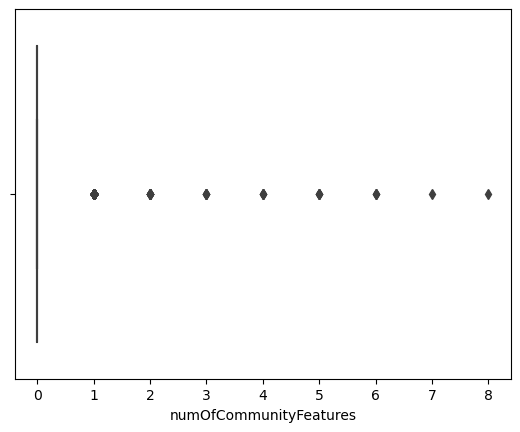

BoxPlot of lotSizeSqFt
----------------------------------------------------------------------------


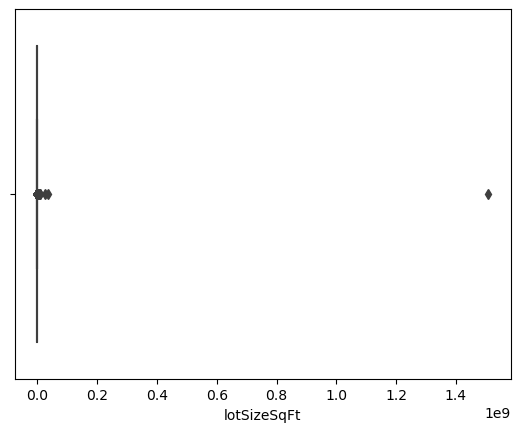

BoxPlot of livingAreaSqFt
----------------------------------------------------------------------------


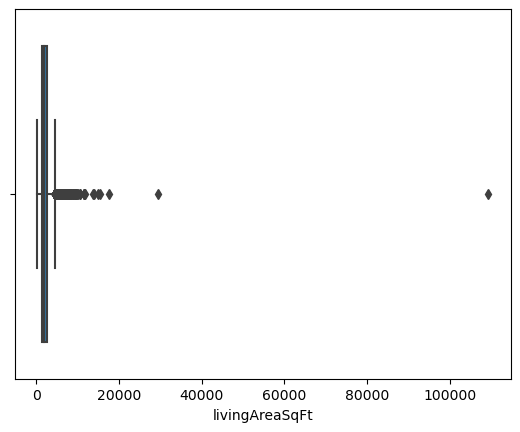

BoxPlot of numOfPrimarySchools
----------------------------------------------------------------------------


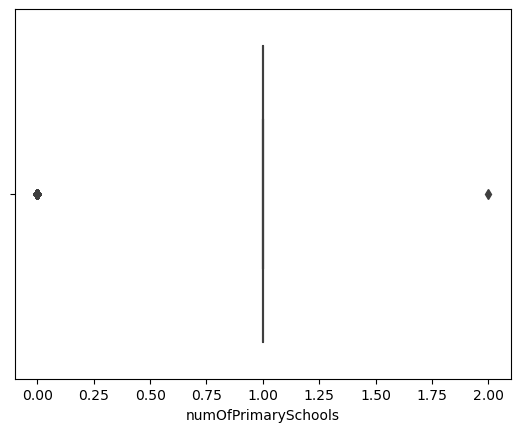

BoxPlot of numOfElementarySchools
----------------------------------------------------------------------------


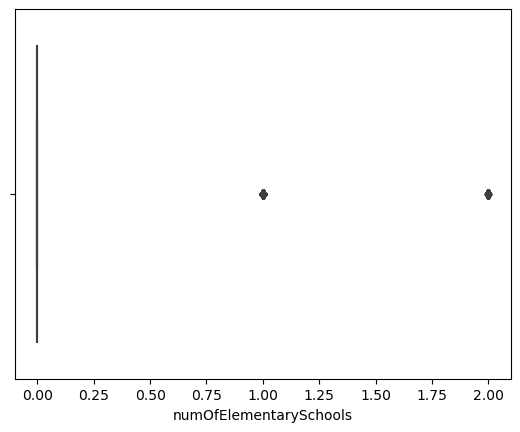

BoxPlot of numOfMiddleSchools
----------------------------------------------------------------------------


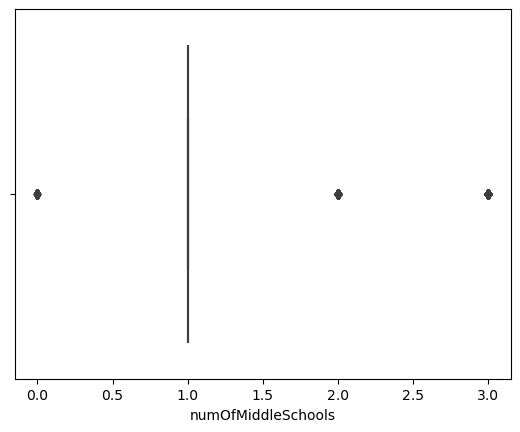

BoxPlot of numOfHighSchools
----------------------------------------------------------------------------


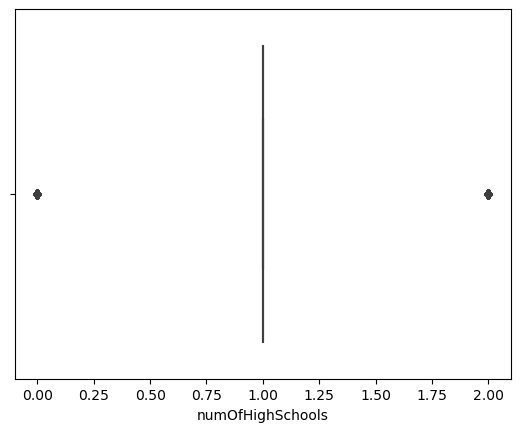

BoxPlot of avgSchoolDistance
----------------------------------------------------------------------------


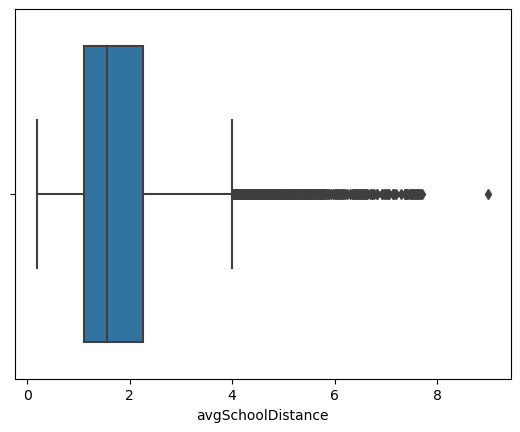

BoxPlot of avgSchoolRating
----------------------------------------------------------------------------


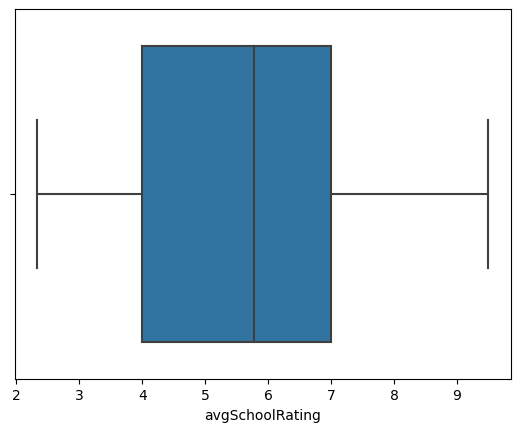

BoxPlot of avgSchoolSize
----------------------------------------------------------------------------


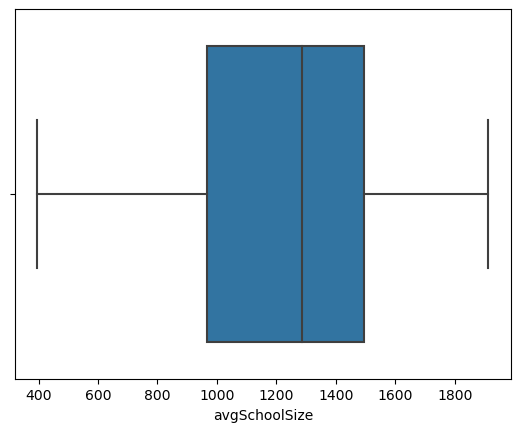

BoxPlot of MedianStudentsPerTeacher
----------------------------------------------------------------------------


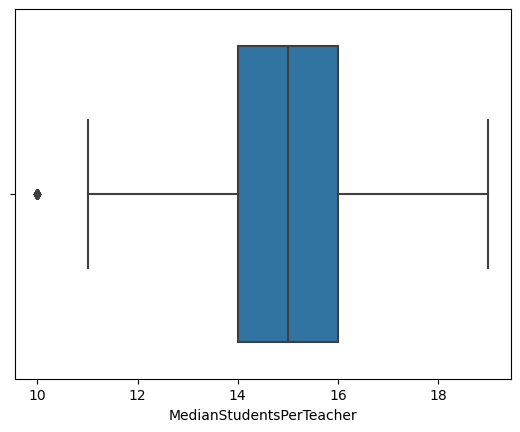

BoxPlot of numOfBathrooms
----------------------------------------------------------------------------


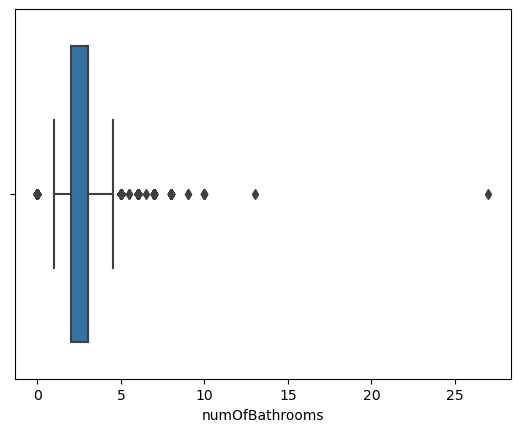

BoxPlot of numOfBedrooms
----------------------------------------------------------------------------


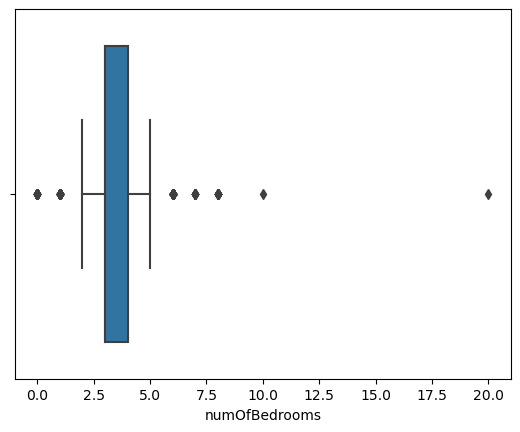

BoxPlot of numOfStories
----------------------------------------------------------------------------


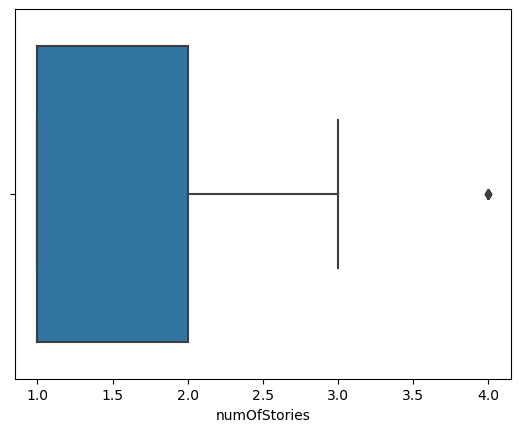

In [44]:
for x in lstnumericcolumns:
    univariateAnalysis_numeric(x,20)

From the box plot we can understand that there is o out lier in the following features.
so we make a list of features with no outliers.
['latest_salemonth', 'latest_saleyear', 'avgSchoolRating', 'avgSchoolSize']

In [45]:
no_outlier = ['latest_salemonth', 'latest_saleyear', 'avgSchoolRating', 'avgSchoolSize']

In [46]:
def treat_outlier(x):
    # taking 5,25,75 percentile of column
    q5= np.percentile(x,5)
    q25=np.percentile(x,25)
    q75=np.percentile(x,75)
    dt=np.percentile(x,95)
    #calculationg IQR range
    IQR=q75-q25
    #Calculating minimum threshold
    lower_bound=q25-(1.5*IQR)
    upper_bound=q75+(1.5*IQR)
    #Calculating maximum threshold
    print(q5,q25,q75,dt,min,max)
    #Capping outliers
    return x.apply(lambda y: dt if y > upper_bound else y).apply(lambda y: q5 if y < lower_bound else y)

In [47]:
outlier_list = [x for x in data_num.columns if x not in no_outlier]

In [48]:
for i in data_num[outlier_list]:    
    data_num[i]=treat_outlier(data_num[i])

1.98 1.98 1.98 2.21 <built-in function min> <built-in function max>
0.0 0.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 2.0 4.0 <built-in function min> <built-in function max>
1949.0 1974.0 2006.0 2017.0 <built-in function min> <built-in function max>
200000.0 309000.0 575000.0 1150000.0 <built-in function min> <built-in function max>
1.0 1.0 4.0 8.0 <built-in function min> <built-in function max>
1.0 20.0 39.0 72.0 <built-in function min> <built-in function max>
0.0 0.0 0.0 0.0 <built-in function min> <built-in function max>
0.0 2.0 4.0 7.0 <built-in function min> <built-in function max>
1.0 1.0 2.0 3.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 3.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 2.0 <built-in function min> <built-in function max>
0.0 0.0 0.0 0.0 <built-in function min> <built-in function max>
0.0 0.0 0.0 1.0 <built-in function min> <built-in function max>
0.0 0.0 0.0 0.0 <built-in function min> <built-in function max>


BoxPlot of propertyTaxRate
----------------------------------------------------------------------------


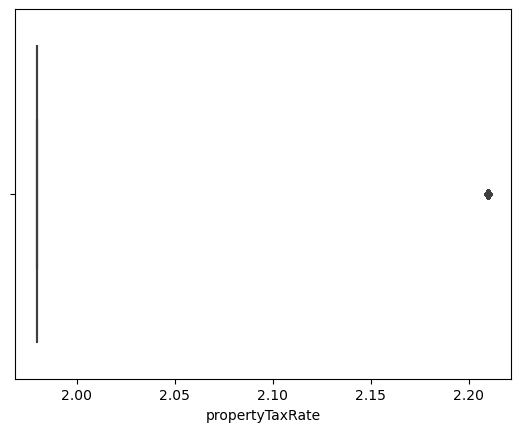

BoxPlot of garageSpaces
----------------------------------------------------------------------------


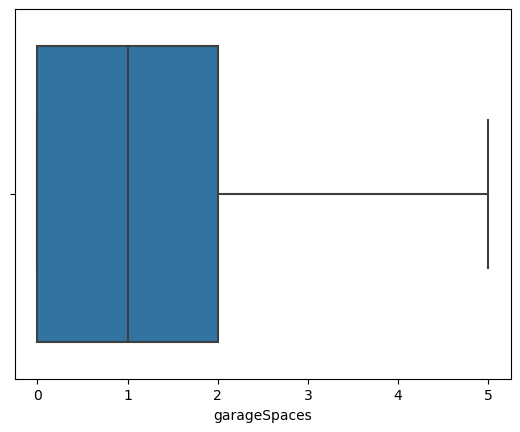

BoxPlot of parkingSpaces
----------------------------------------------------------------------------


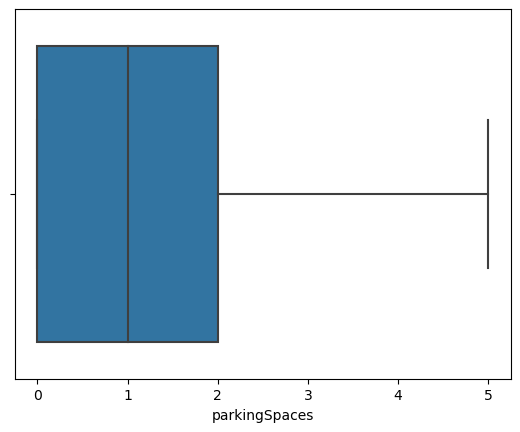

BoxPlot of yearBuilt
----------------------------------------------------------------------------


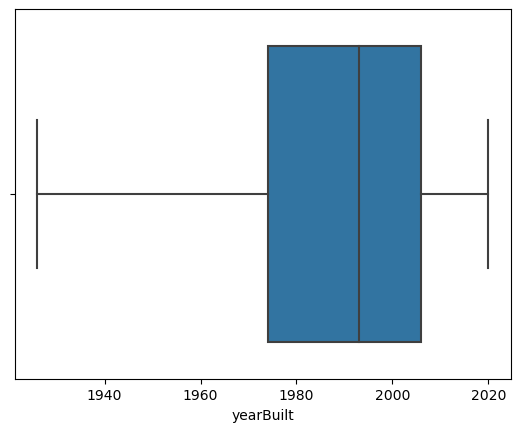

BoxPlot of latestPrice
----------------------------------------------------------------------------


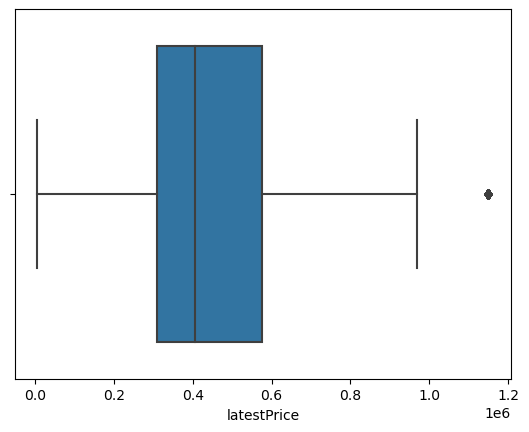

BoxPlot of numPriceChanges
----------------------------------------------------------------------------


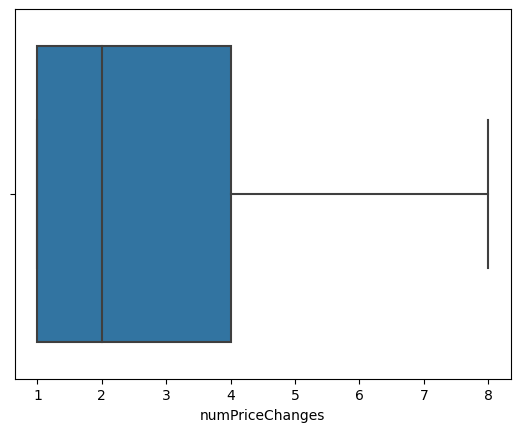

BoxPlot of latest_salemonth
----------------------------------------------------------------------------


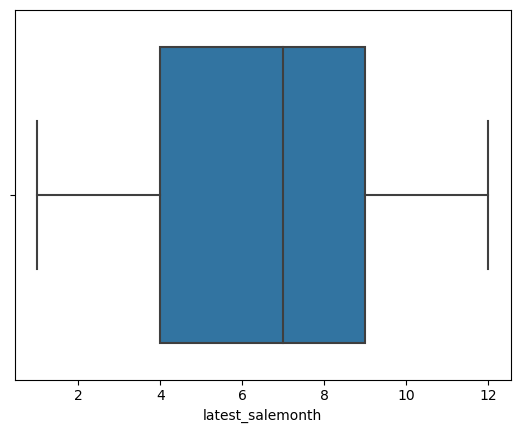

BoxPlot of latest_saleyear
----------------------------------------------------------------------------


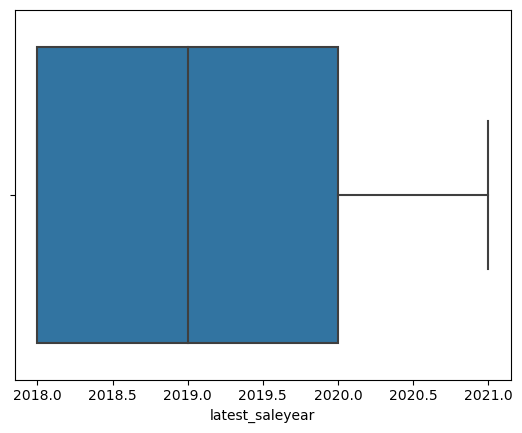

BoxPlot of numOfPhotos
----------------------------------------------------------------------------


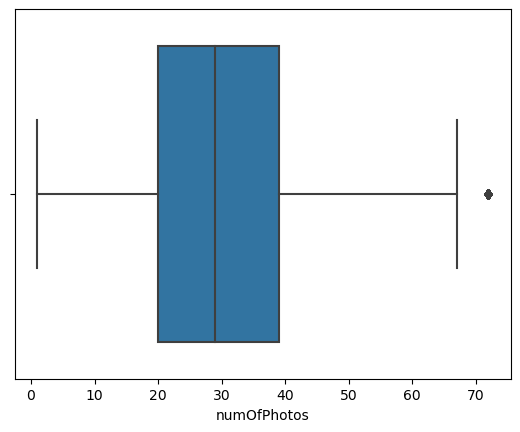

BoxPlot of numOfAccessibilityFeatures
----------------------------------------------------------------------------


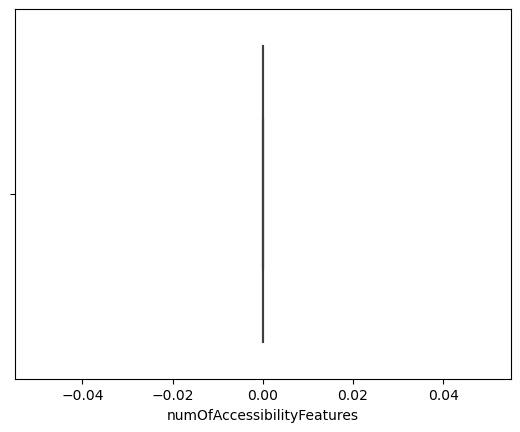

BoxPlot of numOfAppliances
----------------------------------------------------------------------------


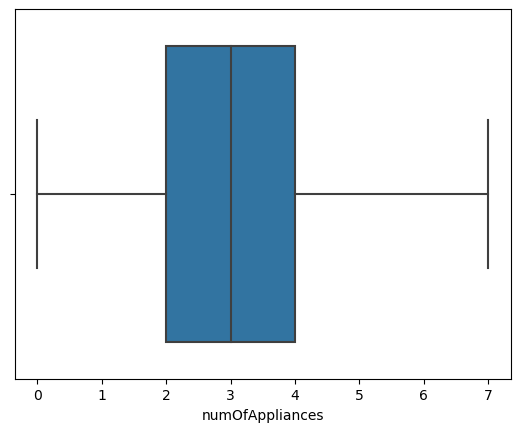

BoxPlot of numOfParkingFeatures
----------------------------------------------------------------------------


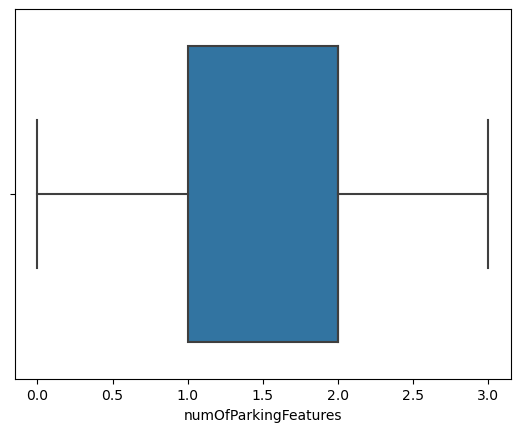

BoxPlot of numOfPatioAndPorchFeatures
----------------------------------------------------------------------------


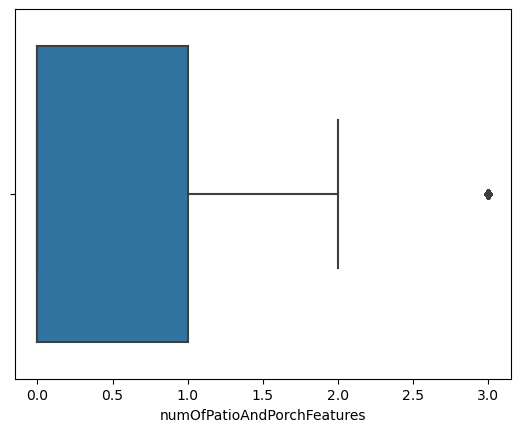

BoxPlot of numOfSecurityFeatures
----------------------------------------------------------------------------


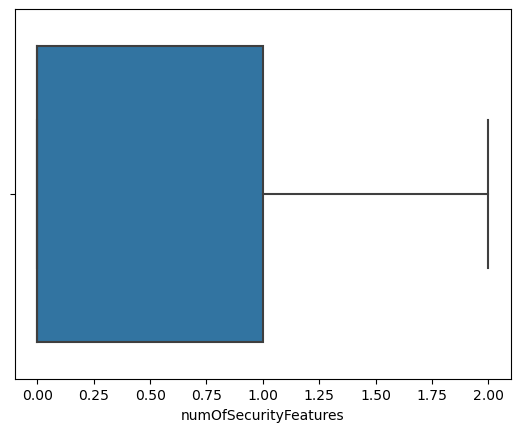

BoxPlot of numOfWaterfrontFeatures
----------------------------------------------------------------------------


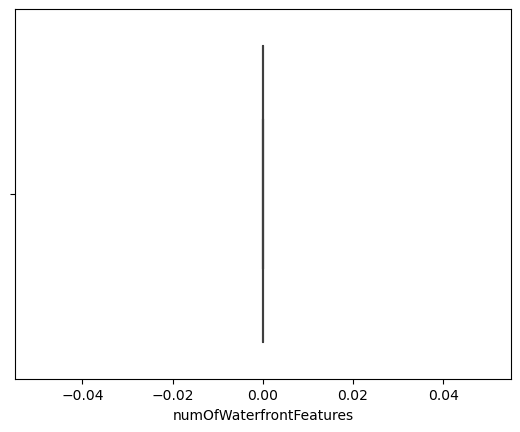

BoxPlot of numOfWindowFeatures
----------------------------------------------------------------------------


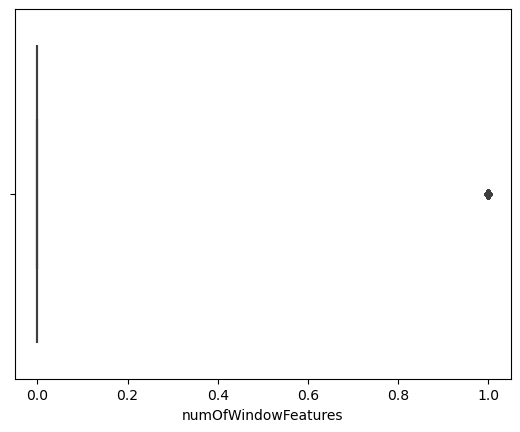

BoxPlot of numOfCommunityFeatures
----------------------------------------------------------------------------


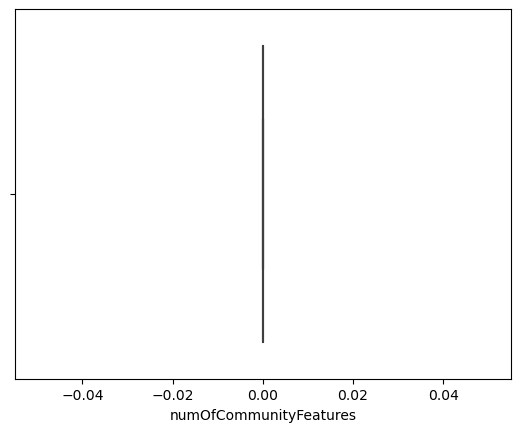

BoxPlot of lotSizeSqFt
----------------------------------------------------------------------------


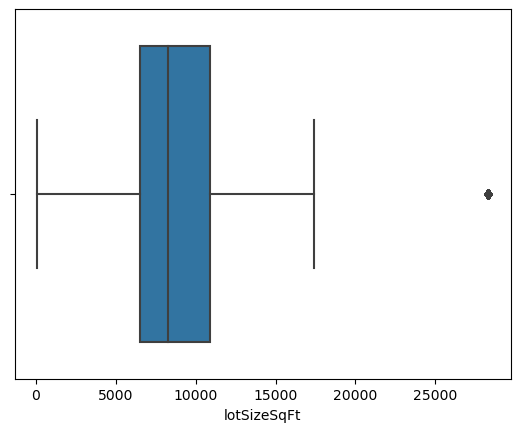

BoxPlot of livingAreaSqFt
----------------------------------------------------------------------------


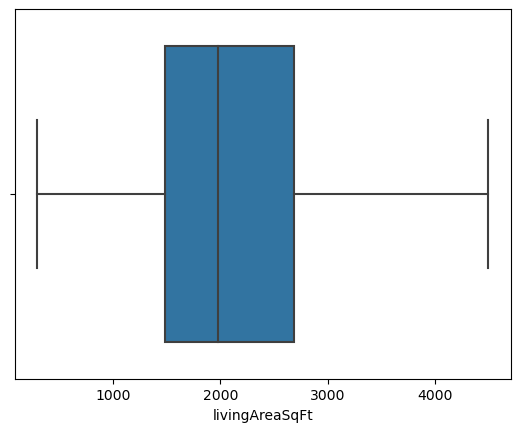

BoxPlot of numOfPrimarySchools
----------------------------------------------------------------------------


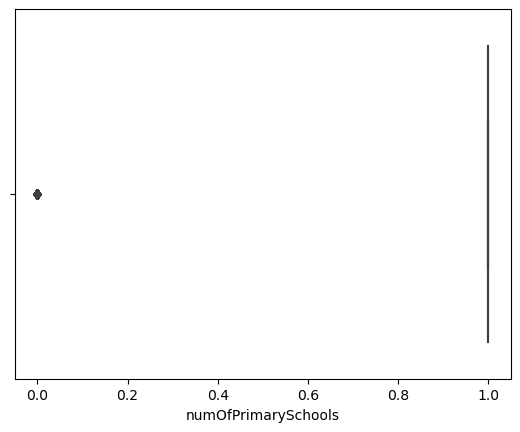

BoxPlot of numOfElementarySchools
----------------------------------------------------------------------------


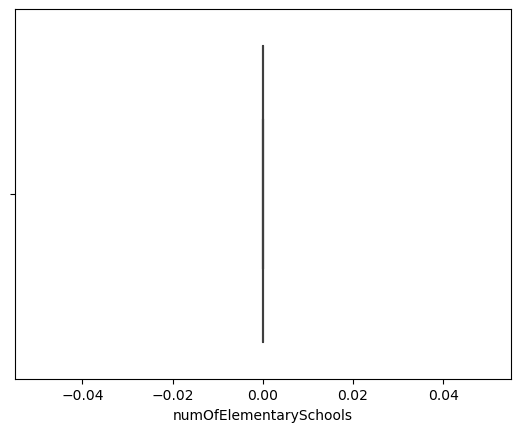

BoxPlot of numOfMiddleSchools
----------------------------------------------------------------------------


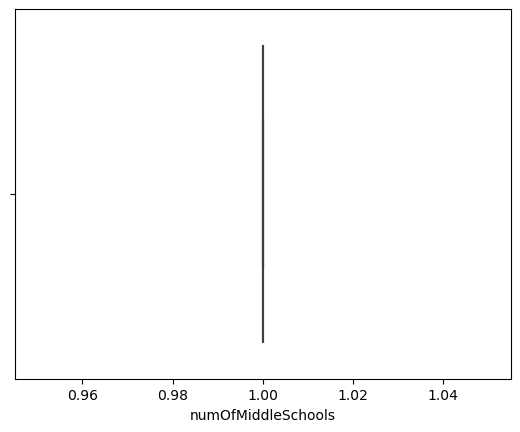

BoxPlot of numOfHighSchools
----------------------------------------------------------------------------


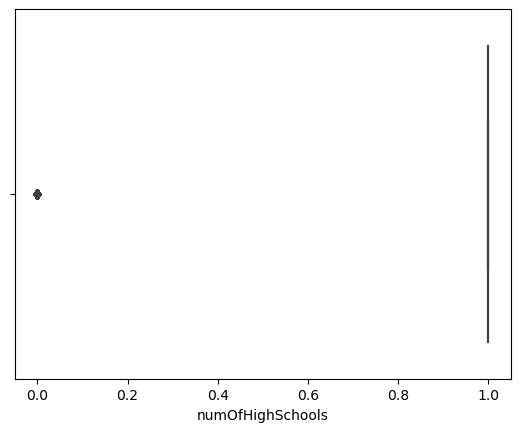

BoxPlot of avgSchoolDistance
----------------------------------------------------------------------------


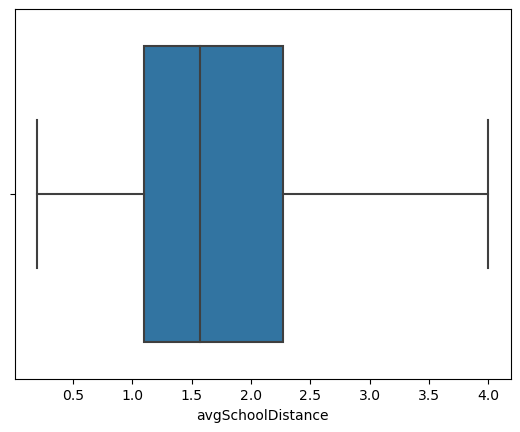

BoxPlot of avgSchoolRating
----------------------------------------------------------------------------


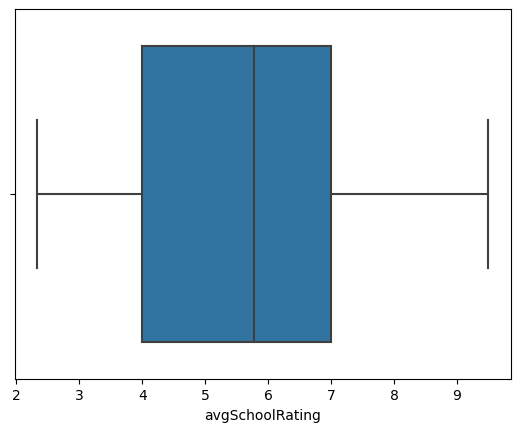

BoxPlot of avgSchoolSize
----------------------------------------------------------------------------


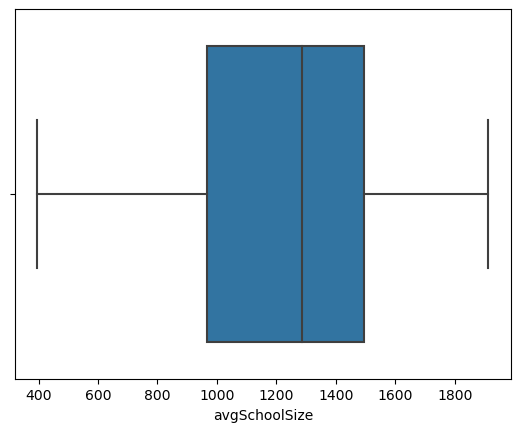

BoxPlot of MedianStudentsPerTeacher
----------------------------------------------------------------------------


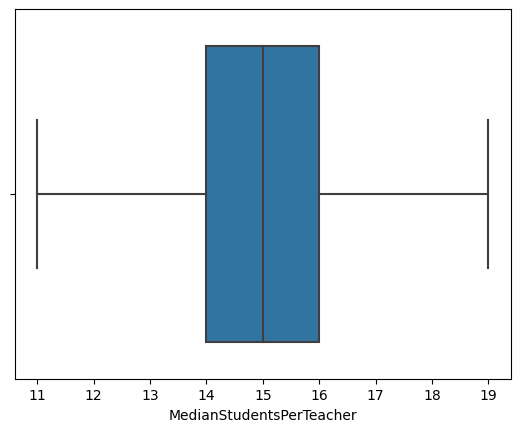

BoxPlot of numOfBathrooms
----------------------------------------------------------------------------


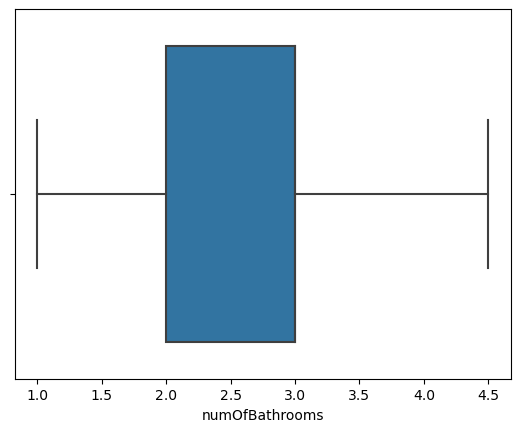

BoxPlot of numOfBedrooms
----------------------------------------------------------------------------


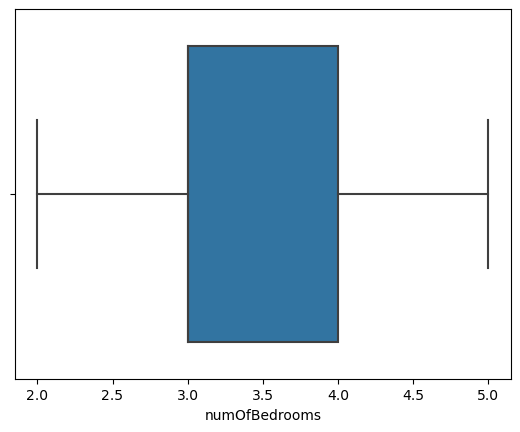

BoxPlot of numOfStories
----------------------------------------------------------------------------


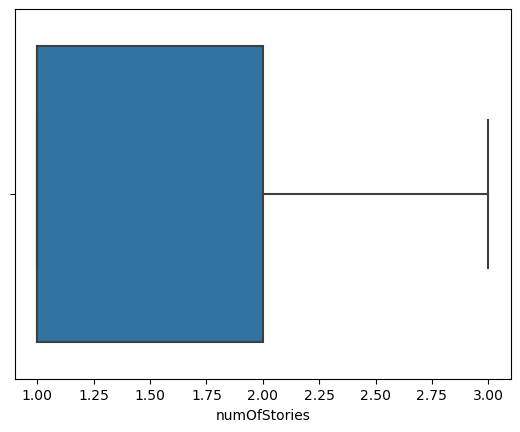

In [49]:
for x in lstnumericcolumns:
    univariateAnalysis_numeric(x,20)

In [50]:
data_num.head()

,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,latest_saleyear,numOfPhotos,numOfAccessibilityFeatures,numOfAppliances,numOfParkingFeatures,numOfPatioAndPorchFeatures,numOfSecurityFeatures,numOfWaterfrontFeatures,numOfWindowFeatures,numOfCommunityFeatures,lotSizeSqFt,livingAreaSqFt,numOfPrimarySchools,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
0,1.98,2.0,2.0,2012.0,305000.0,5.0,9,2019,39.0,0.0,5.0,2.0,1.0,2.0,0.0,1.0,0.0,6011.0,2601.0,1.0,0.0,1.0,1.0,1.266667,2.666667,1063,14.0,3.0,4.0,2.0
1,1.98,2.0,2.0,2013.0,295000.0,1.0,10,2020,29.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,6185.0,1768.0,1.0,0.0,1.0,1.0,1.400000,2.666667,1063,14.0,2.0,4.0,1.0
2,1.98,0.0,0.0,2018.0,256125.0,1.0,7,2019,2.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,7840.0,1478.0,0.0,0.0,1.0,1.0,1.200000,3.000000,1108,14.0,2.0,3.0,1.0
3,1.98,2.0,2.0,2013.0,240000.0,4.0,8,2018,9.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,6098.0,1678.0,1.0,0.0,1.0,1.0,1.400000,2.666667,1063,14.0,2.0,3.0,1.0
4,1.98,0.0,0.0,2002.0,239900.0,3.0,10,2018,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6708.0,2132.0,1.0,0.0,1.0,1.0,1.133333,4.000000,1223,14.0,3.0,3.0,2.0


In [51]:
housing_data.notnull().all().all()

True

In [52]:
for item in outlier_list:
    housing_data[item] = data_num[item]

## Picking Out Useful Attributes

Here I'll be looking at some features to decide what I might be useful for modeling.

### Checking Numerical Attributes:
It is best to begin by looking at how each numerical feature correlates with the price. Below are two bar charts each showing the top 20 features that correlate with price. At appears that #bathrooms correlates the highest at around ~0.5, followed by living area with ~0.47 and then #bedrooms at ~0.3. Some features can be neglected such as 'zipcode' which has no logical connection to the price, and 'numOfPhotos' which comes from Zillow data. Most of the other features on this chart will be considered for modeling.

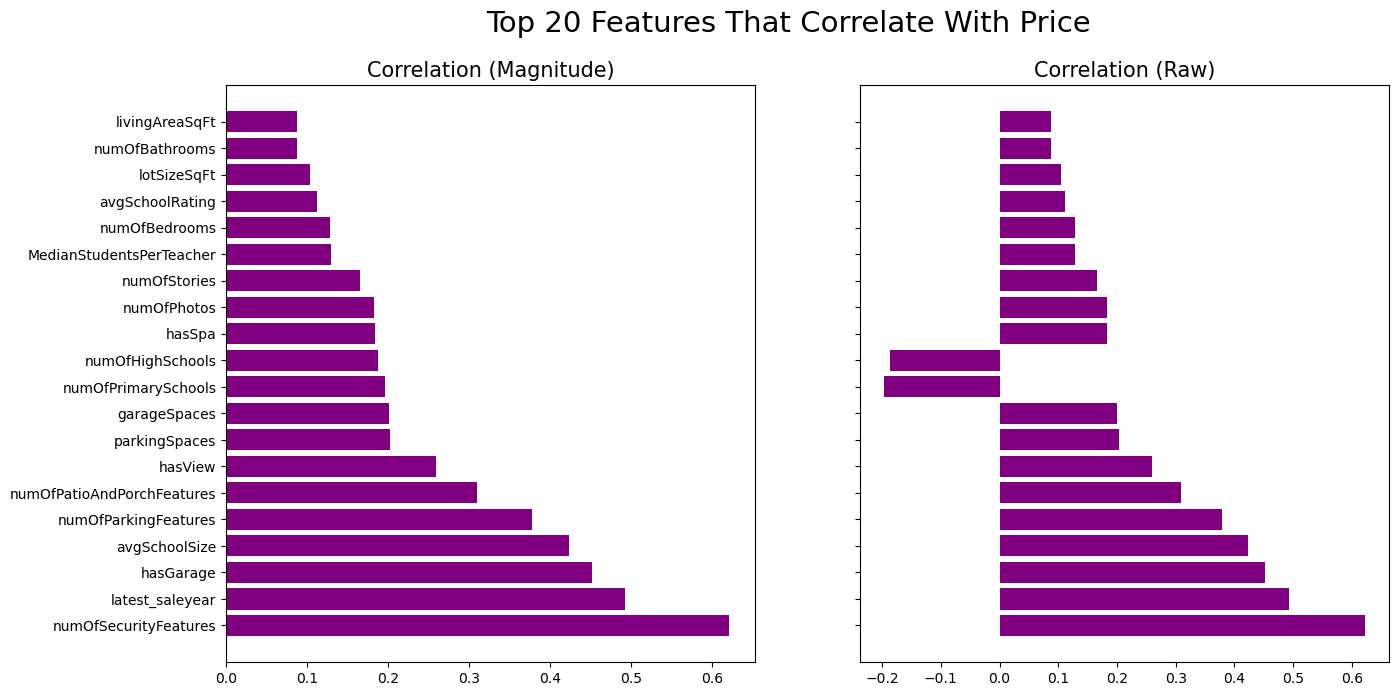

In [53]:
# Just take the absolute value since only magnitude is important
corr_data_abs = housing_data.corr()['latestPrice'].abs().nlargest(21)
corr_data_abs = corr_data_abs.sort_values(axis=0, ascending=False)
corr_data = housing_data[corr_data_abs.axes[0]].corr()['latestPrice']
corr_data_abs = corr_data_abs.drop('latestPrice')
corr_data = corr_data.drop('latestPrice')

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(15, 7.5)
fig.suptitle('Top 20 Features That Correlate With Price', size=21)

ax[0].set_title('Correlation (Magnitude)', size=15)
ax[0].barh(corr_data_abs.axes[0][::-1], corr_data_abs.values, color='purple')
ax[1].set_title('Correlation (Raw)', size=15)
ax[1].barh(corr_data.axes[0][::-1], corr_data.values, color='purple')
plt.show()

In [54]:
correlations = housing_data.corr()['latestPrice'].abs().nlargest(21)
top_21_features = correlations.index.tolist()
top_21_features

['latestPrice',
 'livingAreaSqFt',
 'numOfBathrooms',
 'lotSizeSqFt',
 'avgSchoolRating',
 'numOfBedrooms',
 'MedianStudentsPerTeacher',
 'numOfStories',
 'numOfPhotos',
 'hasSpa',
 'numOfHighSchools',
 'numOfPrimarySchools',
 'garageSpaces',
 'parkingSpaces',
 'hasView',
 'numOfPatioAndPorchFeatures',
 'numOfParkingFeatures',
 'avgSchoolSize',
 'hasGarage',
 'latest_saleyear',
 'numOfSecurityFeatures']

## FROM THE ABOVE FEATURES 
### Obtaining reliable and up-to-date data on average school ratings, sizes, and student-teacher ratios for all relevant schools in the  area can be challenging. The accuracy and consistency of such data can vary, making it less reliable for building a robust predictive model.
### From a practical perspective, including features such as "avgSchoolRating," "avgSchoolSize," and "MedianStudentsPerTeacher" in a residential sales portal can pose challenges for users when entering data.
### so lets remove this feature for training the model.

In [55]:
useful_features = ['latestPrice','livingAreaSqFt','numOfBathrooms','lotSizeSqFt','numOfBedrooms','numOfStories',
 'numOfPhotos','hasSpa','numOfHighSchools','numOfPrimarySchools','garageSpaces','parkingSpaces','hasView',
 'numOfPatioAndPorchFeatures','numOfParkingFeatures','hasGarage','latest_saleyear','numOfSecurityFeatures']

In [56]:
housing_data = housing_data[useful_features]

In [57]:
housing_data

,latestPrice,livingAreaSqFt,numOfBathrooms,lotSizeSqFt,numOfBedrooms,numOfStories,numOfPhotos,hasSpa,numOfHighSchools,numOfPrimarySchools,garageSpaces,parkingSpaces,hasView,numOfPatioAndPorchFeatures,numOfParkingFeatures,hasGarage,latest_saleyear,numOfSecurityFeatures
0,305000.0,2601.0,3.0,6011.0,4.0,2.0,39.0,False,1.0,1.0,2.0,2.0,False,1.0,2.0,True,2019,2.0
1,295000.0,1768.0,2.0,6185.0,4.0,1.0,29.0,False,1.0,1.0,2.0,2.0,False,0.0,2.0,True,2020,0.0
2,256125.0,1478.0,2.0,7840.0,3.0,1.0,2.0,False,1.0,0.0,0.0,0.0,False,0.0,1.0,False,2019,1.0
3,240000.0,1678.0,2.0,6098.0,3.0,1.0,9.0,False,1.0,1.0,2.0,2.0,False,0.0,2.0,True,2018,0.0
4,239900.0,2132.0,3.0,6708.0,3.0,2.0,27.0,False,1.0,1.0,0.0,0.0,False,0.0,1.0,False,2018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15166,330000.0,1234.0,2.0,6534.0,3.0,1.0,49.0,False,1.0,1.0,4.0,4.0,True,3.0,2.0,True,2020,0.0
15167,550000.0,1888.0,4.0,2439.0,3.0,3.0,32.0,True,1.0,1.0,2.0,2.0,True,2.0,2.0,True,2020,1.0
15168,875000.0,1524.0,3.0,9408.0,3.0,2.0,20.0,False,1.0,1.0,2.0,2.0,False,0.0,3.0,True,2021,0.0
15169,420000.0,4043.0,2.0,6098.0,4.0,1.0,15.0,False,1.0,1.0,0.0,0.0,False,0.0,1.0,False,2019,0.0


In [58]:

## for feature slection

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel


In [59]:
x = housing_data.iloc[:,1:].values
y = housing_data.iloc[:,0].values
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=0)


In [60]:
### Apply Feature Selection
# first, I specify the Lasso Regression model, and I
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then I use the selectFromModel object from sklearn, which
# will select the features which coefficients are non-zero

feature_sel_model = SelectFromModel(Lasso(alpha=2000, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(x_train, y_train)


SelectFromModel(estimator=Lasso(alpha=2000, random_state=0))

In [61]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True, False,  True,  True])

In [62]:
# let's print the number of total and selected features
data = housing_data.drop(['latestPrice'],axis = 1) 
# this is how we can make a list of the selected features
selected_feat = data.columns[(feature_sel_model.get_support())]


# let's print some stats
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_sel_model.estimator_.coef_ == 0)))

total features: 17
selected features: 12
features with coefficients shrank to zero: 5


In [63]:
selected_features = list(selected_feat)

In [64]:
selected_features

['livingAreaSqFt',
 'numOfBathrooms',
 'lotSizeSqFt',
 'numOfBedrooms',
 'numOfStories',
 'numOfPhotos',
 'hasSpa',
 'hasView',
 'numOfPatioAndPorchFeatures',
 'numOfParkingFeatures',
 'latest_saleyear',
 'numOfSecurityFeatures']

### Splitting the Data (Train & Test Sets):

For the purposes of modeling, it will be necessary to split the data into at least training and testing sets. Further splitting may be done for cross validation in the training phase. In order to ensure that the test set is representative of the training set, I'll use stratified sampling to make the test set have the same proportion of price categories defined in the data analysis section (as shown in the pie chart).

In [65]:
'''
Function for standardizing the data, and converting boolean values to numerical.
'''
def standardize_dataframe(df, scaler=None):
    # Convert boolean columns to numerical (0 or 1); and standardize numerical columns
    bool_df = df[[col for col in df.columns if df.dtypes[col] == 'bool']].astype('float64')
    num_df = df[[col for col in df.columns if df.dtypes[col] == 'float64'
                 or df.dtypes[col] == 'int64']]
    # If scaler is given, use it. Otherwise train a new scaler on the numerical columns.
    if(scaler==None):
        scaler = StandardScaler().fit(num_df)
    num_df = pd.DataFrame(scaler.transform(num_df), columns=num_df.columns)
    
    # Ensure that bool_df has ascending indices just like num_df (since scaling resets indices)
    bool_df = bool_df.reset_index().drop(['index'], axis=1)
    
    return num_df.join(bool_df), scaler

In [66]:
# Sampling hyperparameters
test_size = 0.2
intervals = [0, 250000, 400000, 600000, 800000, 1500000, housing_data['latestPrice'].max()]
intervals.sort()
price_categories = pd.cut(housing_data['latestPrice'], intervals)

# Split into training and test sets
split_func = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=46)
indices = list(split_func.split(housing_data, price_categories))[0]
training_data, test_data = housing_data.iloc[indices[0]], housing_data.iloc[indices[1]]
x_train, y_train = training_data[selected_features], training_data['latestPrice']
x_test, y_test = test_data[selected_features], test_data['latestPrice']
y_train, y_test = y_train.reset_index()['latestPrice'], y_test.reset_index()['latestPrice']

# Standardize the sets (using only parameters from training set)
x_train, scaler = standardize_dataframe(x_train)
x_test, _ = standardize_dataframe(x_test, scaler)
# Full sets standardized
x, y = pd.concat([x_train, x_test], ignore_index=True), pd.concat([y_train, y_test], ignore_index=True)

Just to be sure that the test data is in fact representative of the training data, we can compare the price labels in each set using a scatter plot. The plot below shows that the training labels (in blue) and the test labels (in red) overlap pretty well, and that each includes a good sample of outliers from the data. The pie charts to the left show the true proportions of price categories in each set. We can see that they are nearly identical, and thus the test set is in fact representative of the training set.

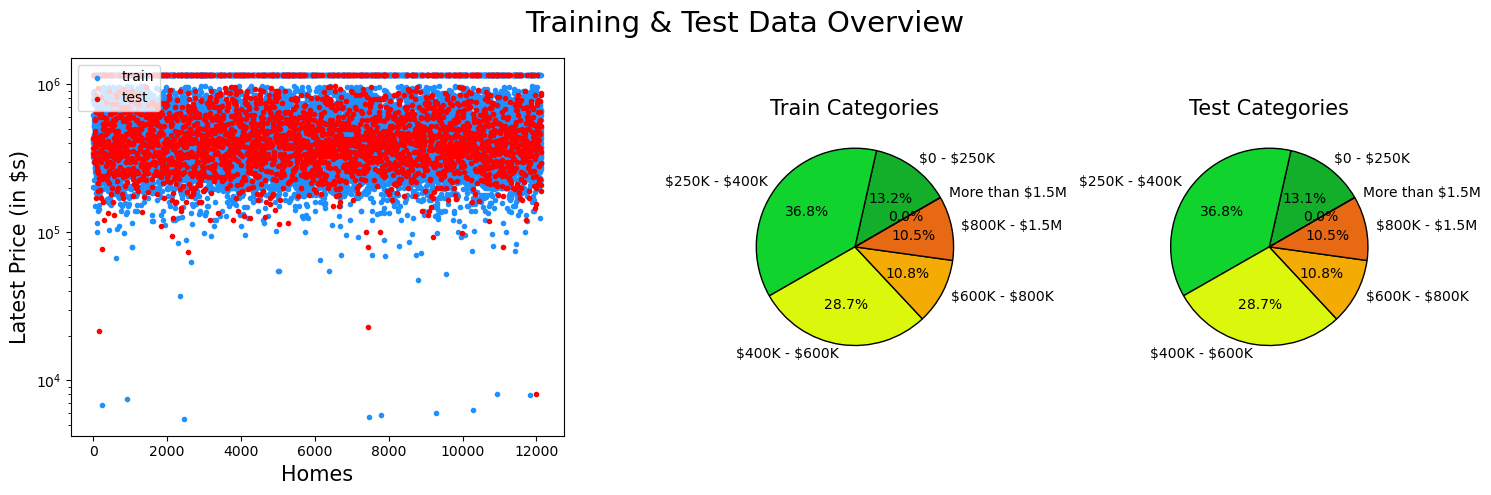

In [67]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [6, 3, 3]})
fig.set_size_inches(15, 5)
fig.suptitle('Training & Test Data Overview', size=21)

# Scatter plot
s1 = ax[0].scatter(np.arange(len(y_train)), y_train, marker='.', color='dodgerblue')
s2 = ax[0].scatter(np.linspace(0, len(y_train), len(y_test)), y_test, marker='.', color='red')
ax[0].legend([s1, s2], ['train', 'test'], loc='upper left')
ax[0].set_ylabel('Latest Price (in $s)', size=15)
ax[0].set_xlabel('Homes', size=15)
ax[0].set_yscale('log')

labels = ['\$0 - \$250K', '\$250K - \$400K', '\$400K - \$600K', '\$600K - \$800K', '\$800K - \$1.5M', 'More than \$1.5M']
colors = ['#13af2a', '#10d32e', '#dbf70c', '#f4ac04', '#e86914', '#f41313']
intervals = [0, 250000, 400000, 600000, 800000, 1500000, housing_data['latestPrice'].max()]  # in $s
intervals.sort()
# Pie chart (Train set)
chart_slice_sizes = training_data.groupby(pd.cut(training_data['latestPrice'], intervals)).size().values
ax[1].set_title('Train Categories', size=15)
ax[1].pie(chart_slice_sizes, labels=labels, colors=colors, startangle=30, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})

# Pie chart (Test set)
chart_slice_sizes = test_data.groupby(pd.cut(test_data['latestPrice'], intervals)).size().values
ax[2].set_title('Test Categories', size=15)
ax[2].pie(chart_slice_sizes, labels=labels, colors=colors, startangle=30, autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'})

fig.tight_layout()

plt.show()

# Modeling:
In this section I'll be creating models to predict the price of a home based on its other features.

The cell below defines several functions for saving and loading models.

In [89]:
model_dir = '/home/yadhu_sudhan/MEGA/PROJECT/SUYATI/SUYATI PROJECT/models/'
linear_regressor_name = "linear_regressor"
decision_tree_regressor_name = "decision_tree_regressor"
random_forest_regressor_name = "random_forest_regressor"
neural_regressor_name = "neural_regressor"

def save_sklearn_model(model, model_name):
    with open(model_dir + model_name + '.pkl', 'wb') as file:  pickle.dump(model, file)

def load_sklearn_model(model_name):
    with open(model_dir + model_name + '.pkl', 'rb') as file:
        model = pickle.load(file)
    return model

### Predictions Function:

Prediction function for **Scikit models** only. Displays a scatter plot of predicted price vs. actual price, and a table that shows the difference between actual and predicted values for a sample from the dataset. If *showline*=True, then a red line will be displayed showing the theoretical optimum (where all values are predicted exactly).

In [69]:
def show_predictions(model, x, y, n_samples=9, random=False, showline=True):
    # Prediction generation
    rand_idx = np.random.randint(0, len(x)-n_samples)
    x_sample = x[rand_idx:n_samples+rand_idx] if (random) else x[:n_samples]
    y_sample = y[rand_idx:n_samples+rand_idx] if (random) else y[:n_samples]
    model_pred = np.around(model.predict(x_sample))
    
    # Plot creation
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [11, 1]})
    fig.set_size_inches(12, 8)

    # Scatter plot
    ax[0].set_title("Actual vs. Predicted Price", size=18)
    ax[0].scatter(y, model.predict(x), marker='.', color='dodgerblue')
    if(showline):
        line_vals = np.linspace(housing_data['latestPrice'].min(), housing_data['latestPrice'].max())
        ax[0].plot(line_vals, line_vals, color='lightcoral')
    ax[0].set_xlabel('Actual Price (in $s)', size=14)
    ax[0].set_ylabel('Predicted Price (in $s)', size=14)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    # Predictions Table
    label_col_cell_ratio = 2
    col_widths = np.array([label_col_cell_ratio] + list(np.ones(n_samples)))
    col_widths = list(col_widths / col_widths.sum())
    table_grid = [
        ["Model Predictions (in $s)"] + list(model_pred),
        ["Actual Values (in $s)"] + list(y_sample.values),
        ["Difference (in $s)"] + list(np.abs(model_pred - y_sample.values))
    ]
    ax[1].set_title("Sample Predictions", size=18, pad=-20)
    t = ax[1].table(table_grid, loc='bottom', colWidths=col_widths)
    t.auto_set_font_size(False)
    ax[1].tick_params(left=False, bottom=False)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    
    fig.tight_layout(h_pad=2)
    
    
   

## Regression:

Since we are trying to predict a continuous value, it is a good idea to start by using regression. Rather than train on the training set once and evaluating on the test set, I'm going to use cross validation with k=10 in order to evaluate how linear regression performs generally on unseen data. I'll use *neg_mean_squared_error* as the scoring method since cross validation assumes the score should be maximized, but we want to *minimize* the error; which is the same as maximizing the negative of the error. I'll use the square root of the mean of the score across all folds (mean rmse) as my final evaluation.

**NOTE:** Since cross validation already splits the given data into training and testing; we can pass in the entire dataset and see how the model performs on different folds (splits).

In [77]:
model = LinearRegression()

# Cross-validation
cv_scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=10)
print("Linear Regressor Mean RMSE Score:\t" + str(np.around(np.sqrt(np.abs(cv_scores)).mean(), 2)))

# Train
model.fit(x_train, y_train)

# Save Model
save_sklearn_model(model, linear_regressor_name)

Linear Regressor Mean RMSE Score:	186140.11


In [80]:
from sklearn.metrics import r2_score

model = LinearRegression()

# Cross-validation
cv_scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=10)
rmse = np.sqrt(np.abs(cv_scores)).mean()
print("Linear Regressor Mean RMSE Score:\t" + str(np.around(rmse, 2)))

# Train
model.fit(x_train, y_train)

# Calculate R-square and adjusted R-square
y_train_pred = model.predict(x_train)
r2 = r2_score(y_train, y_train_pred)
n = len(y_train)
p = x_train.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Display R-square and adjusted R-square
print("R-square:\t\t\t" + str(np.around(r2, 2)))
print("Adjusted R-square:\t" + str(np.around(adjusted_r2, 2)))

# Save Model
save_sklearn_model(model, linear_regressor_name)


Linear Regressor Mean RMSE Score:	186140.11
R-square:			0.44
Adjusted R-square:	0.44


### Predictions:

This cell will display a plot showing how the model predictions compare with the actual price values. A strong linear correlation indicates that the model is performing well, while a non-linear / scattered-looking plot indicates that the model performed poorly.

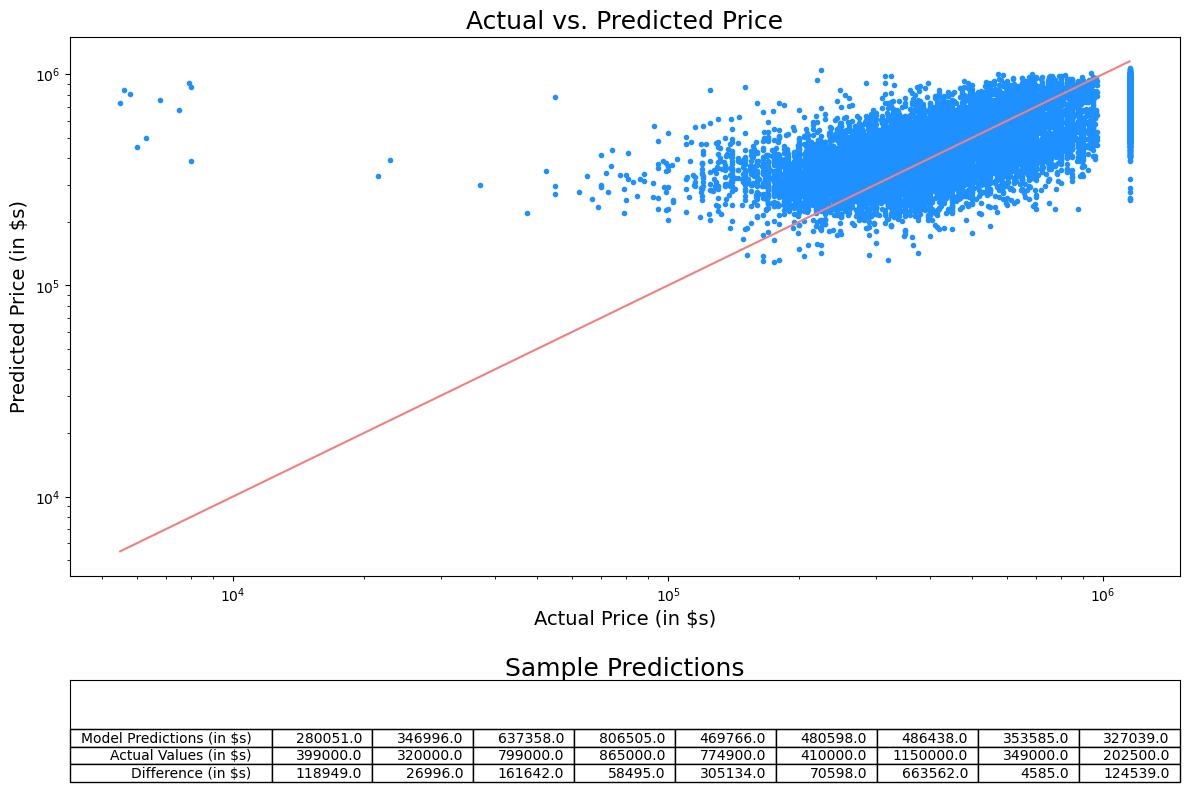

In [81]:
model = load_sklearn_model(linear_regressor_name)
show_predictions(model, x, y, showline=True)

## Decision Tree Regressor:

Since linear regression failed to give desirable results, I'll try to use some other models with more complex decision boundaries. A decision tree regressor might be a good candidate. Unlike simple regression; decision trees have a lot of hyperparameters such as max depth, minimum samples per leaf, and so on. It is a good idea to explore these hyperparameters, so I'll use Scikit-learn's GridSearchCV module to easily explore several options. This module performs cross validation internally for each combination of hyperparameters and outputs the best combination. However, depending on the sample of data it works on, it may come out with different answers. Thus, I'll use nested cross validation to hold out a test set and see what grid search outputs on different folds. I'll use these results to decide which hyperparameters to choose for the final model.

In [82]:
model = DecisionTreeRegressor()

# Nested cross-validation for hyperparameter search
params = {'max_depth': [6, 8, 12, 16], 'min_samples_leaf': [4, 6, 8, 10, 12, 16], 'max_features': ['auto', 'sqrt']}
grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
cv = cross_validate(grid_search, x, y, return_estimator=True, scoring='neg_mean_squared_error', cv=5)

/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

In [83]:
# Import necessary libraries
from sklearn.metrics import r2_score

# Evaluating Results
print("Best Model Parameters on Each Fold:\n")
for i, gs, score in zip(range(len(cv['test_score'])), cv['estimator'], cv['test_score']):
    y_pred = gs.predict(x)
    r2 = r2_score(y, y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Fold '+str(i)+': ', gs.best_params_, '\tRMSE Score: ', np.around(np.sqrt(np.abs(score)), 2))
    print('\tR-squared: ', np.around(r2, 2), '\tAdjusted R-squared: ', np.around(adjusted_r2, 2))

# Select best parameters
best_params = dict()
best_params['max_features'] = 'auto'
best_params['min_samples_leaf'] = 12

# Final Model Selection (trying different max-depths among those found during evaluation)
best_model, best_depth, best_error = None, 0, 1e11
for depth in [8, 12, 16]:
    model = DecisionTreeRegressor(max_depth=depth, max_features=best_params['max_features'],
                                  min_samples_leaf=best_params['min_samples_leaf'])
    # Evaluate using CV on the entire dataset
    cv_scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=5)
    mean_rmse_error = np.sqrt(np.abs(cv_scores)).mean()
    if(mean_rmse_error < best_error):
        best_error = mean_rmse_error
        best_depth = depth
        model.fit(x, y)
        best_model = model
best_params['max_depth'] = best_depth

print("\nBest Model Parameters:\t", best_params)
print("\nBest Model RMSE Score:\t", np.around(best_error, 2))

# Calculate R-squared and adjusted R-squared for the best model
y_pred = best_model.predict(x)
r2 = r2_score(y, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
print("Best Model R-squared:\t", np.around(r2, 2))
print("Best Model Adjusted R-squared:\t", np.around(adjusted_r2, 2))

# Save model
save_sklearn_model(best_model, decision_tree_regressor_name)
print("\nSaved Model Location:\t" + model_dir + decision_tree_regressor_name + '.pkl')


Best Model Parameters on Each Fold:

Fold 0:  {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 6} 	RMSE Score:  190837.93
	R-squared:  0.49 	Adjusted R-squared:  0.48
Fold 1:  {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 12} 	RMSE Score:  187272.75
	R-squared:  0.48 	Adjusted R-squared:  0.48
Fold 2:  {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 6} 	RMSE Score:  181260.01
	R-squared:  0.49 	Adjusted R-squared:  0.49
Fold 3:  {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 8} 	RMSE Score:  186246.57
	R-squared:  0.49 	Adjusted R-squared:  0.49
Fold 4:  {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 10} 	RMSE Score:  181965.55
	R-squared:  0.49 	Adjusted R-squared:  0.48


/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl


Best Model Parameters:	 {'max_features': 'auto', 'min_samples_leaf': 12, 'max_depth': 8}

Best Model RMSE Score:	 186607.08
Best Model R-squared:	 0.53
Best Model Adjusted R-squared:	 0.53

Saved Model Location:	/home/yadhu_sudhan/MEGA/PROJECT/SUYATI/SUYATI PROJECT/models/decision_tree_regressor.pkl


/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


/home/yadhu_sudhan/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


Best Model R-squared:	 0.46
Best Model Adjusted R-squared:	 0.46


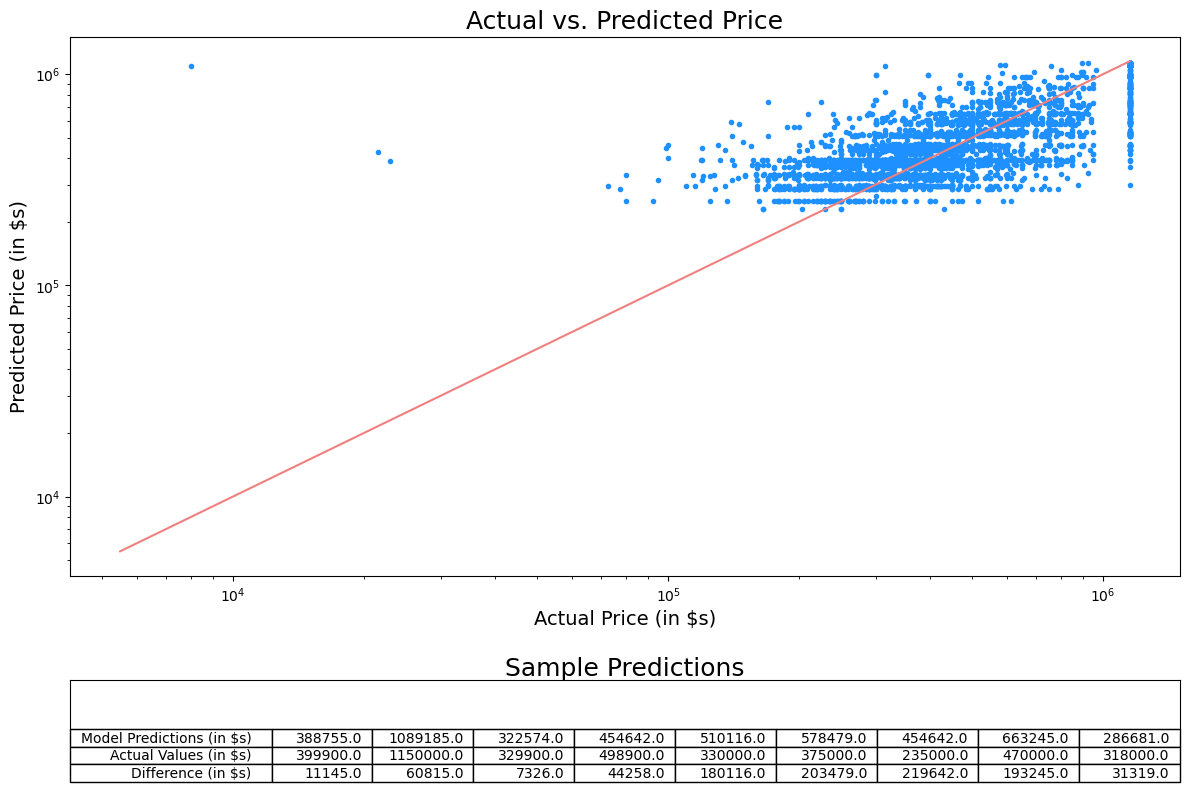

In [84]:
best_params = {'max_features': 'auto', 'min_samples_leaf': 12, 'max_depth': 8}
model = DecisionTreeRegressor(max_depth=best_params['max_depth'], max_features=best_params['max_features'],
                              min_samples_leaf=best_params['min_samples_leaf'])
model.fit(x_train, y_train)

show_predictions(model, x_test, y_test, random=True, showline=True)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
print("Best Model R-squared:\t", np.around(r2, 2))
print("Best Model Adjusted R-squared:\t", np.around(adjusted_r2, 2))


In [85]:
model = RandomForestRegressor()

# Nested cross-validation for hyperparameter search
params = {'n_estimators':[10, 50, 100], 'max_features':[4, 6, 10, 12]}
grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
cv = cross_validate(grid_search, x, y, return_estimator=True, scoring='neg_mean_squared_error', cv=5)

In [86]:
# Import necessary libraries
from sklearn.metrics import r2_score

# Evaluating Results
print("Best Model Parameters on Each Fold:\n")
for i, gs, score in zip(range(len(cv['test_score'])), cv['estimator'], cv['test_score']):
    y_pred = gs.predict(x)
    r2 = r2_score(y, y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Fold '+str(i)+': ', gs.best_params_, '\tR-squared: ', np.around(r2, 2), '\tAdjusted R-squared: ', np.around(adjusted_r2, 2))
    print('\tRMSE Score: ', np.around(np.sqrt(np.abs(score)), 2))
   

# Select best parameters
best_params = dict()
best_params['n_estimators'] = 100
best_params['max_features'] = 4

# Final Model Training
model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_features=best_params['max_features'])
model.fit(x, y)
cv_scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=5)
error = np.sqrt(np.abs(cv_scores)).mean()

print("\nBest Model Parameters:\t", best_params)
print("\nBest Model RMSE Score:\t", np.around(error, 2))

# Calculate R-squared and adjusted R-squared for the best model
y_pred = model.predict(x)
r2 = r2_score(y, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
print("Best Model R-squared:\t", np.around(r2, 2))
print("Best Model Adjusted R-squared:\t", np.around(adjusted_r2, 2))

# Save model
save_sklearn_model(model, random_forest_regressor_name)
print("\nSaved Model Location:\t" + model_dir + random_forest_regressor_name + '.pkl')


Best Model Parameters on Each Fold:

Fold 0:  {'max_features': 4, 'n_estimators': 100} 	R-squared:  0.84 	Adjusted R-squared:  0.84
	RMSE Score:  182715.61
Fold 1:  {'max_features': 4, 'n_estimators': 100} 	R-squared:  0.84 	Adjusted R-squared:  0.84
	RMSE Score:  181812.11
Fold 2:  {'max_features': 4, 'n_estimators': 100} 	R-squared:  0.85 	Adjusted R-squared:  0.85
	RMSE Score:  173429.8
Fold 3:  {'max_features': 4, 'n_estimators': 100} 	R-squared:  0.84 	Adjusted R-squared:  0.84
	RMSE Score:  182794.77
Fold 4:  {'max_features': 4, 'n_estimators': 100} 	R-squared:  0.84 	Adjusted R-squared:  0.84
	RMSE Score:  173577.66

Best Model Parameters:	 {'n_estimators': 100, 'max_features': 4}

Best Model RMSE Score:	 178656.85
Best Model R-squared:	 0.93
Best Model Adjusted R-squared:	 0.93

Saved Model Location:	/home/yadhu_sudhan/MEGA/PROJECT/SUYATI/SUYATI PROJECT/models/random_forest_regressor.pkl


Best Model R-squared:	 0.52
Best Model Adjusted R-squared:	 0.52


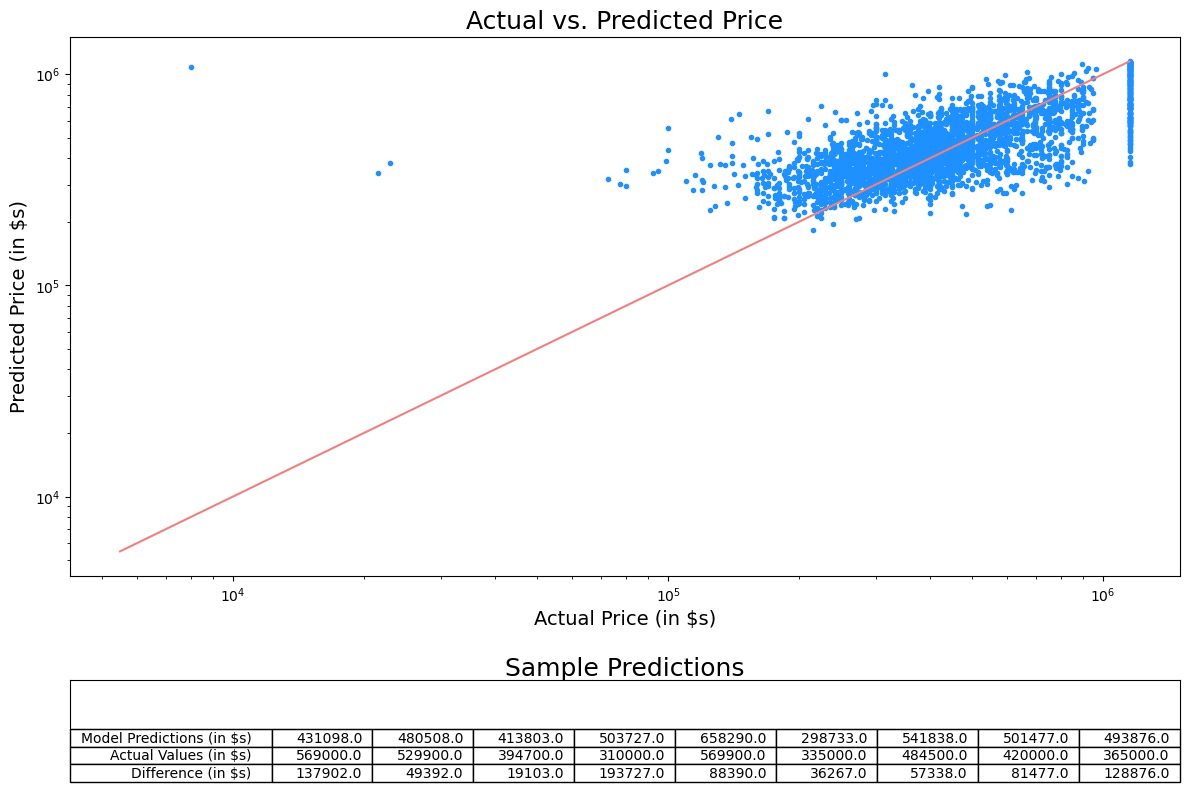

In [87]:
#best_params = {'n_estimators': 100, 'max_features': 4}
#model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_features=best_params['max_features'])
model = RandomForestRegressor(n_estimators=100, max_features=4)
model.fit(x_train, y_train)

show_predictions(model, x_test, y_test, random=True)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)
print("Best Model R-squared:\t", np.around(r2, 2))
print("Best Model Adjusted R-squared:\t", np.around(adjusted_r2, 2))


## From models build,till now random forest show a better perfomance compared to other so it is attached to the backend.It will be replaced by the new model after doing the required changes to increase the accuracy.

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

# Create a deep learning neural network regressor
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(12,)))  # Replace input_dim with the appropriate input dimension
model.add(Dropout(0.2))  # Add dropout layer for regularization
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Output layer with 1 unit for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict on training data
y_train_pred = model.predict(x_train)

# Calculate R2 score
r2 = r2_score(y_train, y_train_pred)
print("R-square:\t\t\t" + str(r2))

# Save Model (if you have a custom save function)
save_sklearn_model(model, neural_regressor_name)

Epoch 1/50


304/304 [==============================] - 1s 3ms/step - loss: 289236975616.0000 - val_loss: 290042347520.0000
Epoch 2/50
304/304 [==============================] - 1s 2ms/step - loss: 284810477568.0000 - val_loss: 280665587712.0000
Epoch 3/50
304/304 [==============================] - 1s 2ms/step - loss: 268766937088.0000 - val_loss: 256766853120.0000
Epoch 4/50
304/304 [==============================] - 1s 2ms/step - loss: 238385676288.0000 - val_loss: 219414413312.0000
Epoch 5/50
304/304 [==============================] - 1s 2ms/step - loss: 197315592192.0000 - val_loss: 174448721920.0000
Epoch 6/50
304/304 [==============================] - 1s 2ms/step - loss: 154074644480.0000 - val_loss: 133686566912.0000
Epoch 7/50
304/304 [==============================] - 1s 2ms/step - loss: 119034757120.0000 - val_loss: 103821901824.0000
Epoch 8/50
304/304 [==============================] - 1s 2ms/step - loss: 95542116352.0000 - val_loss: 85711724544.0000
Epoch 9/50
304/304 [=================

## From models build,till now random forest show a better perfomance.